# Binning code

## Make sure the code that creates the binned_dic you care about is here. Just copy and paste it into a new cell after this one if it isn't

In [1]:
import pandas as pd
import numpy as np
import time as t

#filename = 'wfC318/Day_4/raw_files_csv/combined_behavior_and_s.csv'
filename = 'wfC318/Day_0/Raw_files_csv/combined_behavior_and_s.csv'

# How many trials we are looking at (ex: 31 for day 0, 34 for day 4)
trial_count = 31

data = pd.read_csv(filename, header=None)

def changeTime(data_name):
    trial_prev, time_prev, end_time = 0,0,0
    for i, j in data_name.iterrows():
        trial = int(j[9])
        time = int(j[1])
        if trial != trial_prev:
            end_time = time_prev
        data_name.at[i,1] = time - end_time
        trial_prev = trial
        time_prev = time
    print("time changed")
    
changeTime(data)

length = len(data)
#data = data[data[7] <= 4000]  # removing all rows where mouse is licking reward past 4000cm

time = data[1]
odor = data[10]
distance = data[7]
lap = data[9]
# neuron data starts at column "13", indexed from 0 so the first column of neuron data is data[12]
cell = data.loc[:, 12:(len(data.columns)-1)]  # neuron data

#trial_count = max(lap)  # all of them

lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    lap_dictionary[i] = data.loc[data[9] == i]  # associate all lap data with that lap

def findShortestTrial():
    min_time = 999999999
    max_time = 0
    shortest_trial = lap_dictionary[0]
    longest_trial = lap_dictionary[0]
    time_list = []
    for trial in lap_dictionary:
        # first row where mouse passes 4000cm, indicated by lapCount increment
        first = lap_dictionary[trial].loc[ lap_dictionary[trial][5] > trial ]
        #print(first)
        last = lap_dictionary[trial].iloc[-1]
        time = last[1] - first.iloc[0,1]
        #print(last[1], first.iloc[0,1], time)
        time_list.append(time)
        if(time < min_time):
            min_time = time
            shortest_trial = trial
        if (time > max_time):
            max_time = time
            longest_trial = trial
    return shortest_trial, min_time, longest_trial, max_time

shortest_trial, min_time,longest_trial, max_time = findShortestTrial()
print("Shortest Trial:", shortest_trial, "Time: ", min_time)
print("Longest Trial:", longest_trial, "Time: ", max_time)


# Determining number of bins
num_of_time_bins = int(min_time // 200)
num_of_space_bins = 4000//100 # 100cm bin width 
print("number of time bins:", num_of_time_bins)

NEW_lap_dictionary = {}
for i in range(0, trial_count):  # for every lap
    NEW_lap_dictionary[i] = data.loc[(data[9] == i) & (data[7] > 4000)]  # associate all lap data with that lap
    #print(NEW_lap_dictionary[i])

def timeBinning():
    # each key value pair will be (Trial_number, [ [Bin1], [Bin2], [Bin3], ..., [Bin43] ])
    dict_of_all_bins = {}
    for i in NEW_lap_dictionary:  # for every trial
        #print("TEST", NEW_lap_dictionary[i], "\n\n")
        list_of_bins = {}  # each (key,value) pair will be start-time of bin and list of points in bin for each trial
        # indexed from 1
        first = NEW_lap_dictionary[i].loc[ NEW_lap_dictionary[i][5] > i ]
        #print("HEREEE", first)
        inceptionTIME = first.iloc[0,1]
        
        #inceptionTIME = 
        for bin_number in range(1, num_of_time_bins+1):
            bin_ending_time = bin_number*200
            last_time = (bin_number-1)*200
            # add all data points from the current trial in lap_dictionary to bin if time is in bin range
            data_points = NEW_lap_dictionary[i].loc[(NEW_lap_dictionary[i][1] < bin_ending_time + inceptionTIME) & (NEW_lap_dictionary[i][1] >= last_time+inceptionTIME) ]
            list_of_bins[bin_ending_time] = data_points
            #print(data_points)
        dict_of_all_bins[i] = list_of_bins

    return dict_of_all_bins
time_binned_dict_day0_reward = timeBinning()
print("temporally binned dictionary")

time changed
Shortest Trial: 20 Time:  4250.0
Longest Trial: 9 Time:  4652.0
number of time bins: 21
temporally binned dictionary


# Reshaping data for shuffle test

## NOTE: reset the value of "binned_dic" to match the dictionary you are analyzing


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 

#Set binned_dic = whatever dictionary you care about
#this should work as long as the data is binned according to TIME
binned_dic = time_binned_dict_day0_reward

times,cells,spikes,t = [],[],[],[]
data_dic = {}
for trial,bin in binned_dic.items():
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell <= 12:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            t.append(trial)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    #data_dic["trial"] = trials
    data_dic["trial"] = t
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

df = pd.DataFrame.from_dict(data_dic)

print(df.head())

   trial  times  cells  spikes
0      0    200     13     0.0
1      0    200     14     0.0
2      0    200     15     0.0
3      0    200     16     0.0
4      0    200     17     0.0


# Performs 100 shuffles and stores the distributions in the dictionary "shuffled_spike"

In [5]:
def shuffle_cells(df):
    df1 = df.copy()
    for i in range(13,268):
        cell_i = df[df["cells"] == i]["spikes"]
        arr = np.array(cell_i)
        np.random.shuffle(arr)
        df1.loc[df['cells']==i, 'spikes'] = arr
    return df1

shuffled_spike = {}
def find_time_cells():        
    for i in range(0,100):
        print(i)
        df1 = shuffle_cells(df)
        times = df1["times"]
        cells = df1["cells"]
        spikes = df1["spikes"]
        times_cells = list(zip(times,cells))
        for j in range(0, len(times_cells)):
            x = times_cells[j]
            if x in shuffled_spike:
                shuffled_spike[x].append(spikes[j])
            else:
                shuffled_spike[x] = []
                shuffled_spike[x].append(spikes[j])       

find_time_cells()
print(shuffled_spike)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Compares the spikes from original dataframe (df) to the distributions calculated in the shuffle, and adds the relevant (time,cell) pairs to a dictionary

In [8]:
from scipy import stats

time_cells = {}
c =0

for i, j in df.iterrows():
        time = int(j["times"])
        cell = int(j["cells"])
        spike = float(j["spikes"])
        trial = int(j["trial"])
        if (time,cell) in shuffled_spike:
            arr = np.array(shuffled_spike[(time,cell)])
        else:
            continue
        arr = np.append(arr,spike)
        if np.all(arr==0):
            continue
        nintey_fifth_p = np.percentile(arr, 95)
        if nintey_fifth_p == 0:
            continue
        if spike > nintey_fifth_p:
            if True:
                if cell in time_cells:
                    time_cells[(time, cell)] += 1
                else:
                    time_cells[(time,cell)] = 1
                    
print(time_cells)

139 0.576975 0.37525
137 0.832575 0.491
88 1.135875 0.640125
120 1.639075 0.5137
137 0.601 0.5969
120 1.2011 0.5395
77 0.573375 0.30822
137 0.768825 0.5915
65 1.710375 0.5065
77 1.3858 0.36115
137 0.7931 0.5969
139 0.788175 0.392925
77 5.572 0.19536799999999999
139 4.7551749999999995 0.381425
30 1.05485 0.37974
31 0.873675 0.772525
207 0.7893 0.75225
30 3.374325 0.37974
31 0.923825 0.7187
88 0.883 0.5618
137 1.852275 0.5969
189 0.648625 0.43905
18 0.7053 0.42165
43 0.4879 0.282725
189 2.23085 0.2283575
18 1.079625 0.397125
27 12.203675 0.4001
96 0.5517 0.53535
88 1.204025 0.404725
96 0.73375 0.5034
45 5.153175 0.488625
96 0.791875 0.500725
148 1.737975 0.681675
31 1.170425 0.772525
88 0.857325 0.478775
96 1.35995 0.569
43 0.50045 0.31685
96 0.95155 0.53626
30 0.7424 0.35128
137 0.92645 0.5969
148 1.090425 0.6776
77 0.796425 0.30822
96 1.255575 0.53535
88 1.10475 0.5618
43 0.8491 0.282725
18 0.7081 0.397125
189 0.76205 0.482475
207 2.562 0.786675
30 0.5292 0.42973999999999996
88 0.5258 

20 16.92725 0.8082
82 0.471625 0.44775
124 5.2111 1.288775
31 1.12845 0.7187
45 0.66465 0.4032
148 0.925725 0.59985
207 1.20405 0.786675
35 0.769775 0.48334
31 1.015425 0.717125
65 0.6576 0.462225
137 1.657425 0.5969
18 0.670575 0.42774999999999996
124 2.1557 1.118075
148 0.751325 0.64166
137 0.676675 0.491
207 0.9397 0.7676
20 0.90485 0.74735
139 0.381425 0.37525
65 0.812425 0.484475
139 0.87965 0.29635
18 0.3514 0.34293999999999997
43 0.7537375 0.33465
207 0.883525 0.7676
30 0.537925 0.42973999999999996
45 0.711225 0.488625
207 1.71345 0.75225
158 0.493075 0.26660000000000006
137 0.8908974999999999 0.491
88 1.175375 0.640125
148 0.9007 0.6776
45 0.5102 0.30072
77 0.4396 0.30822
139 0.62985 0.37525
158 0.36055 0.26660000000000006
65 1.206825 0.5065
77 3.10675 0.36115
207 0.786675 0.7676
30 0.650275 0.37974
82 2.465575 0.514025
82 2.200075 0.522225
120 1.0698750000000001 0.5055
186 0.5184 0.3541
139 0.68085 0.381425
18 0.52535 0.42165
65 0.62495 0.484475
120 8.577225 0.4169
120 9.71375

# This takes in the dictionary of time cells (with time fields) and prints out the cell IDs

In [9]:
listypoo = []
for k,v in time_cells.items():
    #print(k, v)
    listypoo.append(k[1])
    
print(set(listypoo))

{137, 139, 145, 18, 148, 20, 27, 30, 31, 158, 35, 43, 45, 186, 189, 63, 65, 202, 77, 207, 82, 88, 96, 120, 124}


# Make heatmap of time cell activity for each trial

binned dic
times  200       400   600   800   1000  1200  1400      1600      1800  \
cells                                                                     
18      0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000  0.336400   
20      0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000   
27      0.0  1.309675   0.0   0.0   0.0   0.0   0.0  0.000000  0.923825   
30      0.0  0.000000   0.0   0.0   0.0   0.0   0.0  1.054850  3.374325   
31      0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.873675  0.923825   

times    2000  ...      2400  2600  2800  3000  3200  3400  3600      3800  \
cells          ...                                                           
18     0.7053  ...   0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
20     0.0000  ...   0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
27     0.0000  ...  10.15675   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
30     0.0000  ...   0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.00000

times  200   400   600   800       1000  1200     1400  1600  1800  2000  ...  \
cells                                                                     ...   
18      0.0   0.0   0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0  ...   
20      0.0   0.0   0.0   0.0  0.000000   0.0  0.53524   0.0   0.0   0.0  ...   
27      0.0   0.0   0.0   0.0  0.652150   0.0  0.00000   0.0   0.0   0.0  ...   
30      0.0   0.0   0.0   0.0  0.557225   0.0  0.00000   0.0   0.0   0.0  ...   
31      0.0   0.0   0.0   0.0  0.475875   0.0  0.59208   0.0   0.0   0.0  ...   

times      2400     2600  2800  3000  3200  3400  3600  3800    4000  4200  
cells                                                                       
18     0.000000  0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  
20     0.000000  0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.0000   0.0  
27     0.000000  0.00000   0.0   0.0   0.0   0.0   0.0   0.0  0.4511   0.0  
30     0.000000  0.00000   0.0   0.0   0.0   0.

times  200   400   600   800   1000  1200      1400     1600       1800  \
cells                                                                     
18      0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.00000   0.000000   
20      0.0   0.0   0.0   0.0   0.0   0.0  1.397575  7.22466  15.812333   
27      0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.00000   0.000000   
30      0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.00000   0.000000   
31      0.0   0.0   0.0   0.0   0.0   0.0  0.000000  0.43582   0.000000   

times     2000  ...      2400  2600      2800  3000  3200  3400  3600  3800  \
cells           ...                                                           
18      0.0000  ...  0.305075   0.0  0.885300   0.0   0.0   0.0   0.0   0.0   
20     17.9985  ...  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   
27      0.0000  ...  0.000000   0.0  0.644900   0.0   0.0   0.0   0.0   0.0   
30      0.0000  ...  0.000000   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   


/home/sophia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


times  200   400   600   800   1000      1200  1400  1600  1800     2000  ...  \
cells                                                                     ...   
18      0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000  ...   
20      0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000  ...   
27      0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0  0.66195  ...   
30      0.0   0.0   0.0   0.0   0.0  0.705375   0.0   0.0   0.0  0.00000  ...   
31      0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0  0.00000  ...   

times      2400  2600  2800  3000      3200  3400  3600  3800  4000  4200  
cells                                                                      
18     0.809325   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
20     0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
27     0.000000   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  
30     0.000000   0.0   0.0   0.0  0.000000   0.0   

times  200       400   600   800   1000  1200  1400  1600      1800  2000  \
cells                                                                       
18      0.0  0.515433   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
20      0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
27      0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
30      0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   
31      0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  0.604675   0.0   

times  ...  2400  2600      2800  3000  3200      3400  3600  3800      4000  \
cells  ...                                                                     
18     ...   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0  0.495275   
20     ...   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0  0.000000   
27     ...   0.0   0.0  0.000000   0.0   0.0  0.741175   0.0   0.0  0.000000   
30     ...   0.0   0.0  0.505875   0.0   0.0  0.000000   0.0

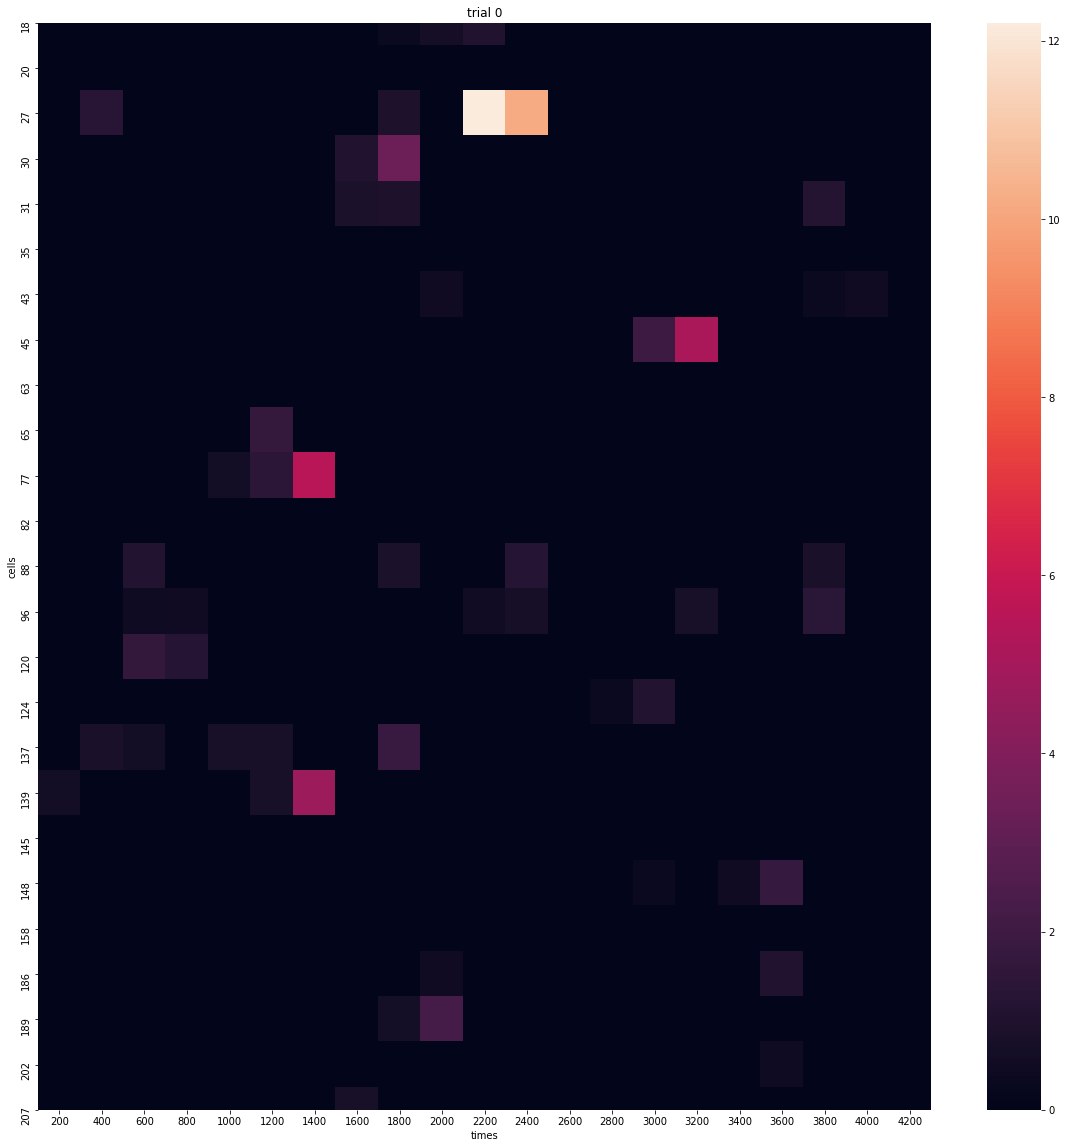

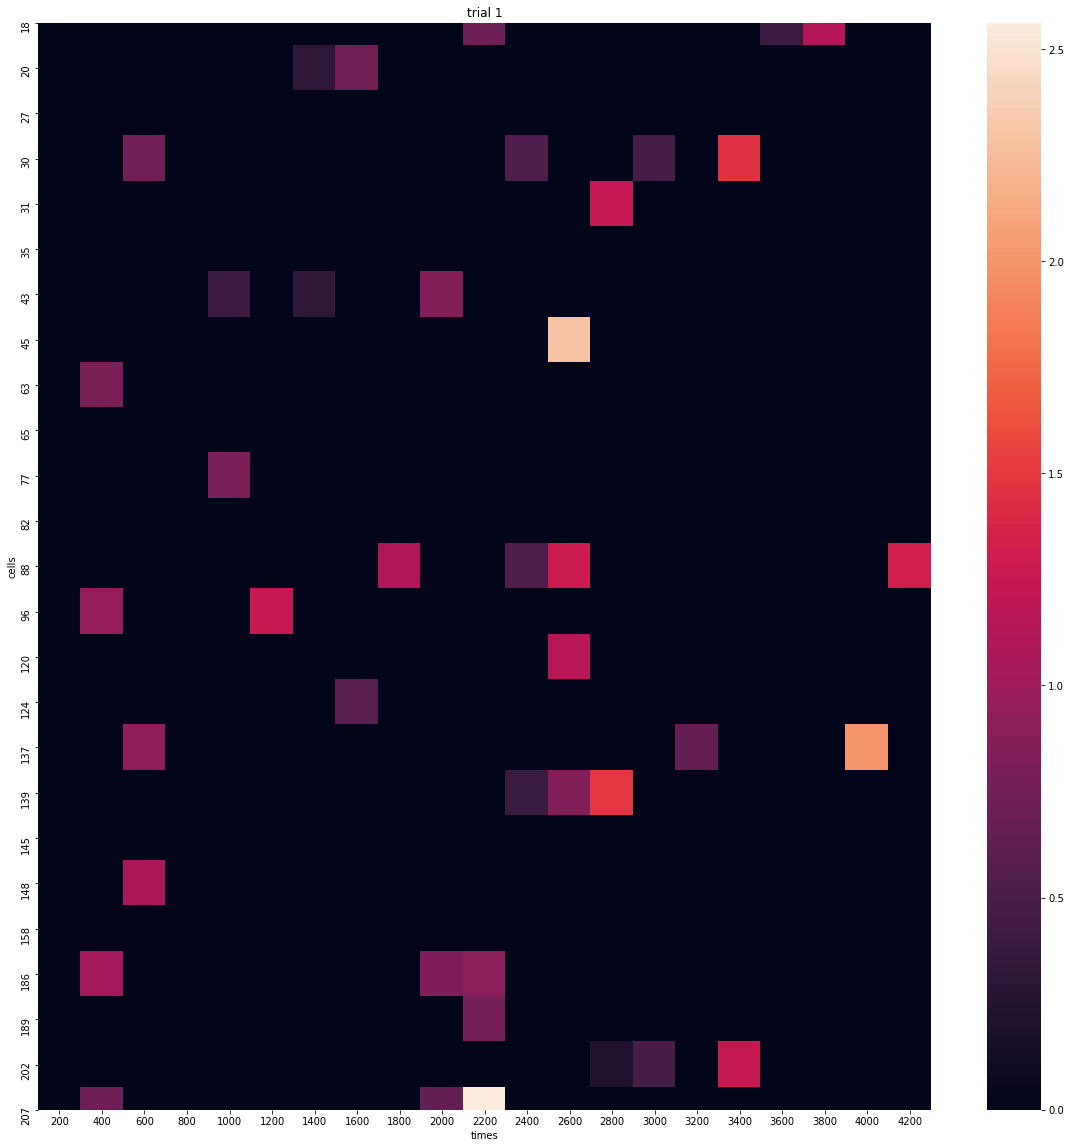

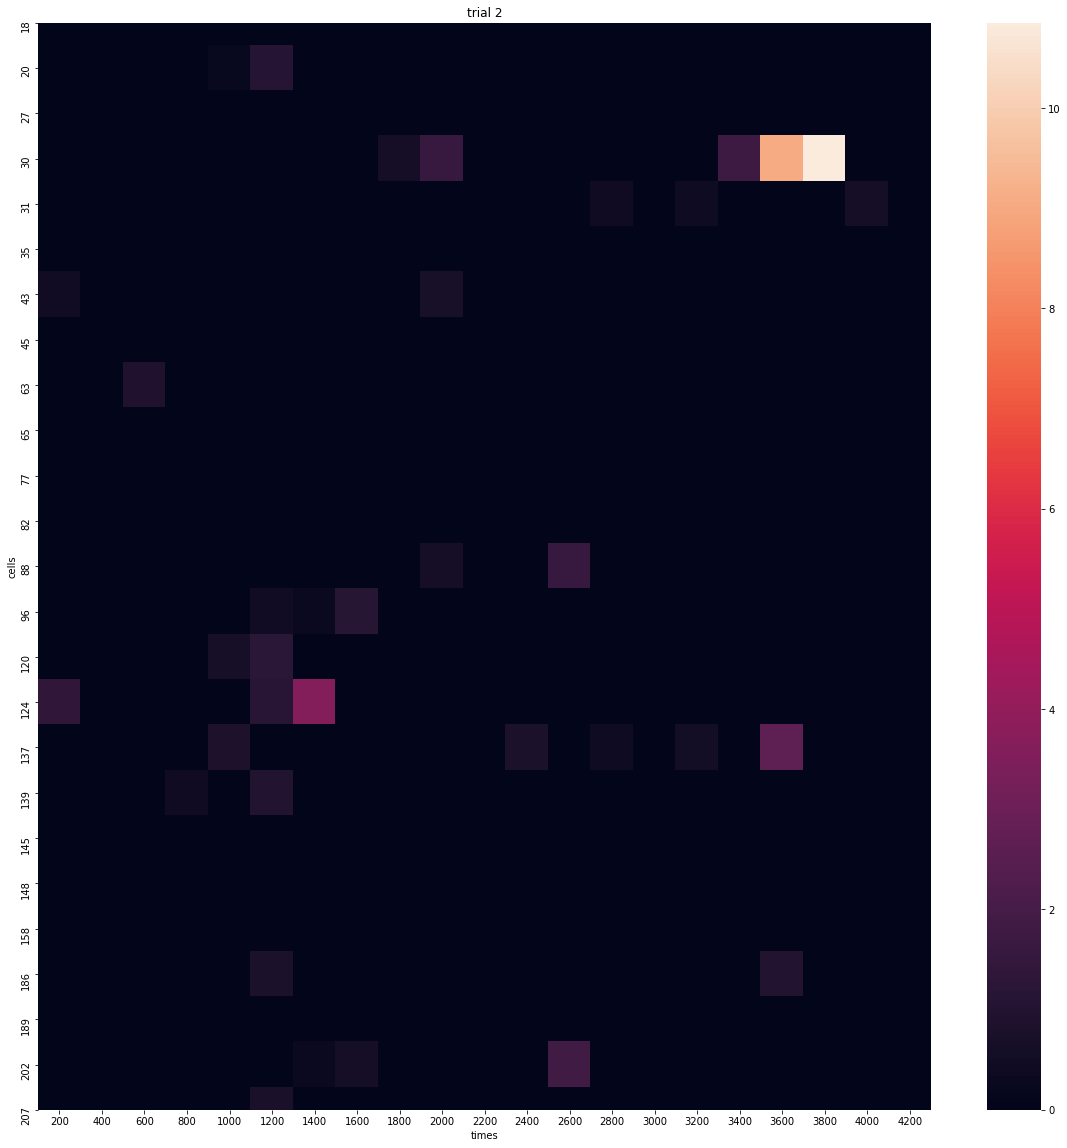

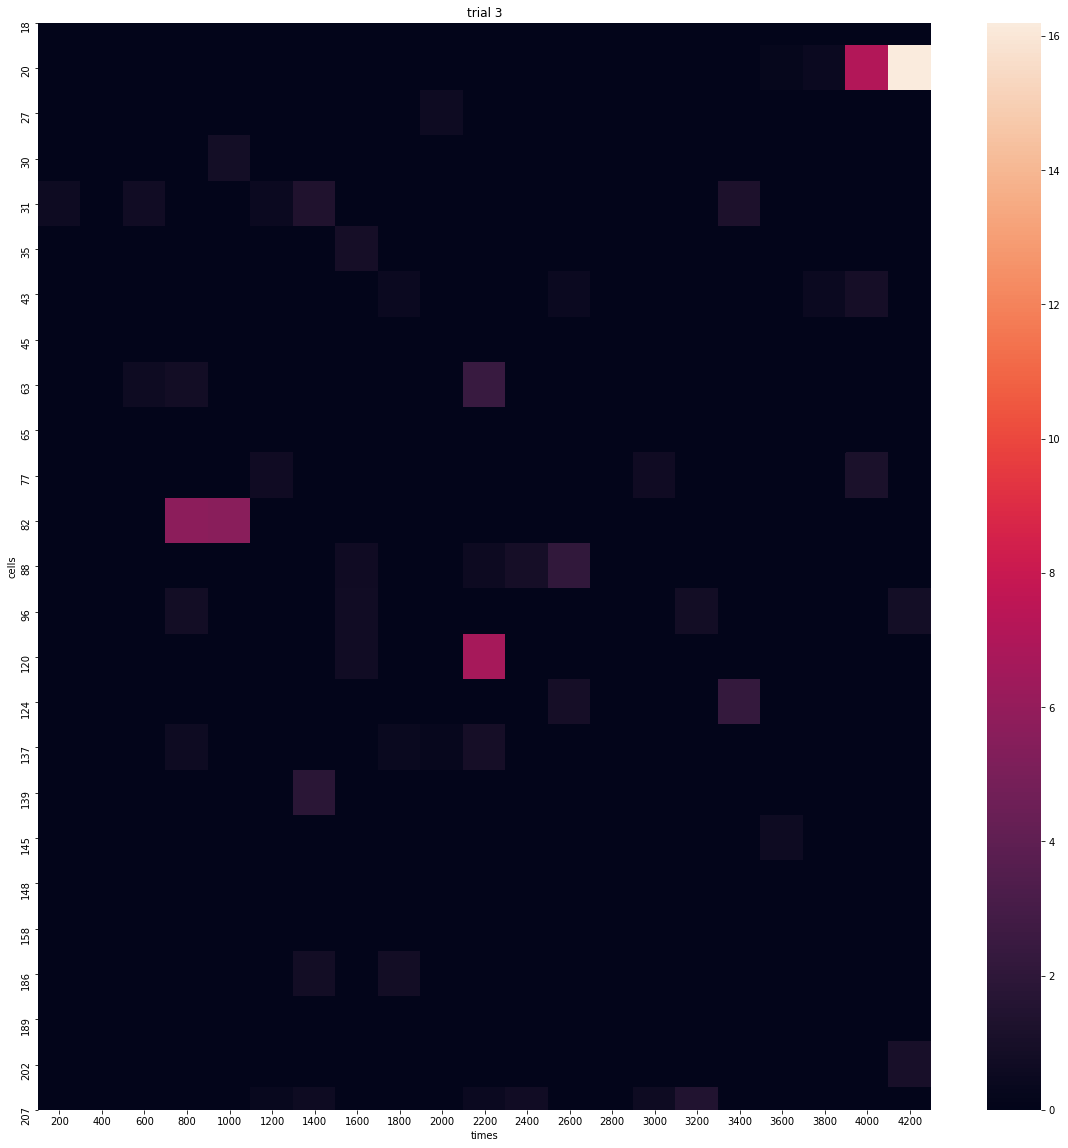

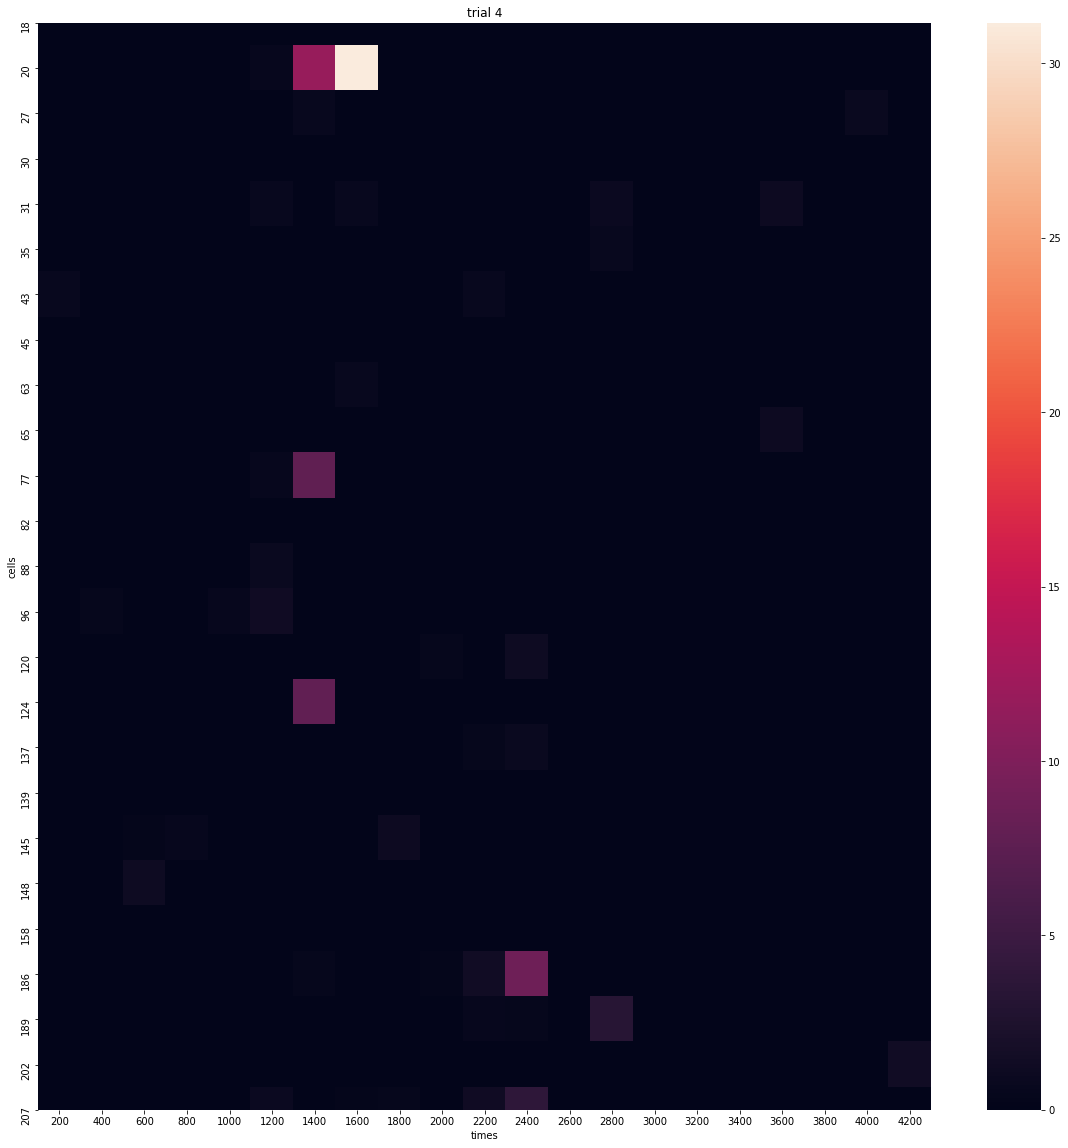

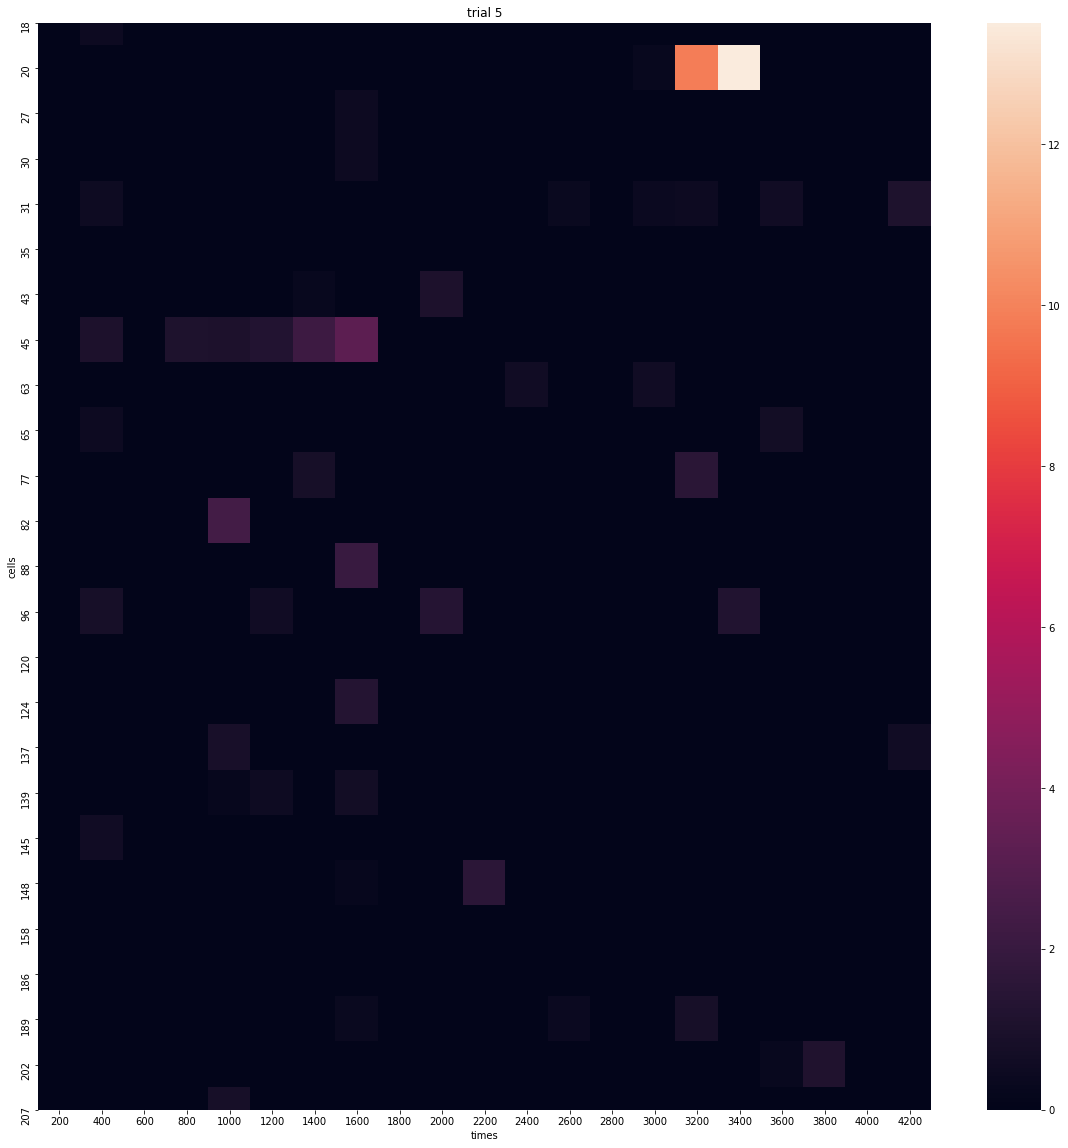

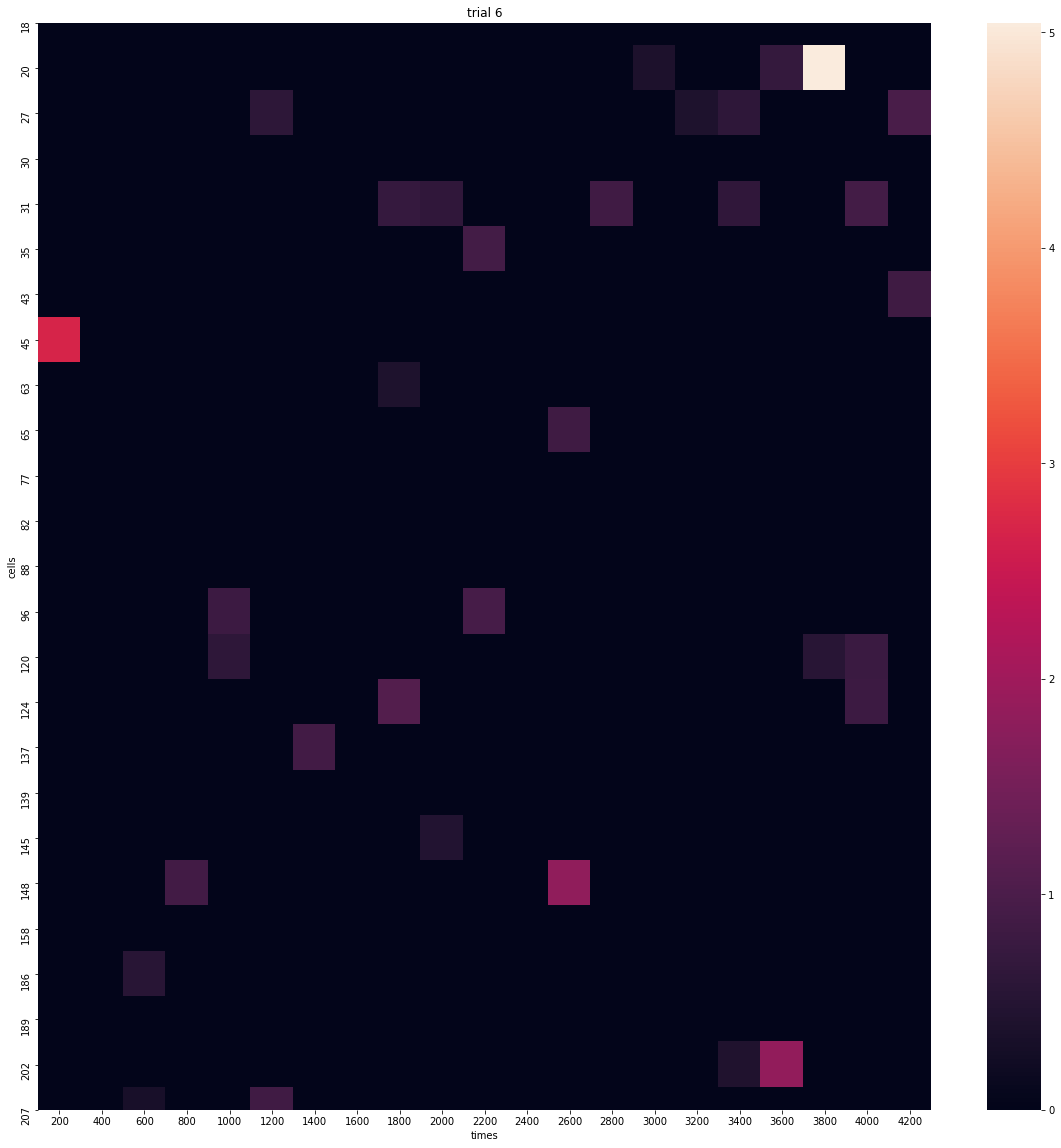

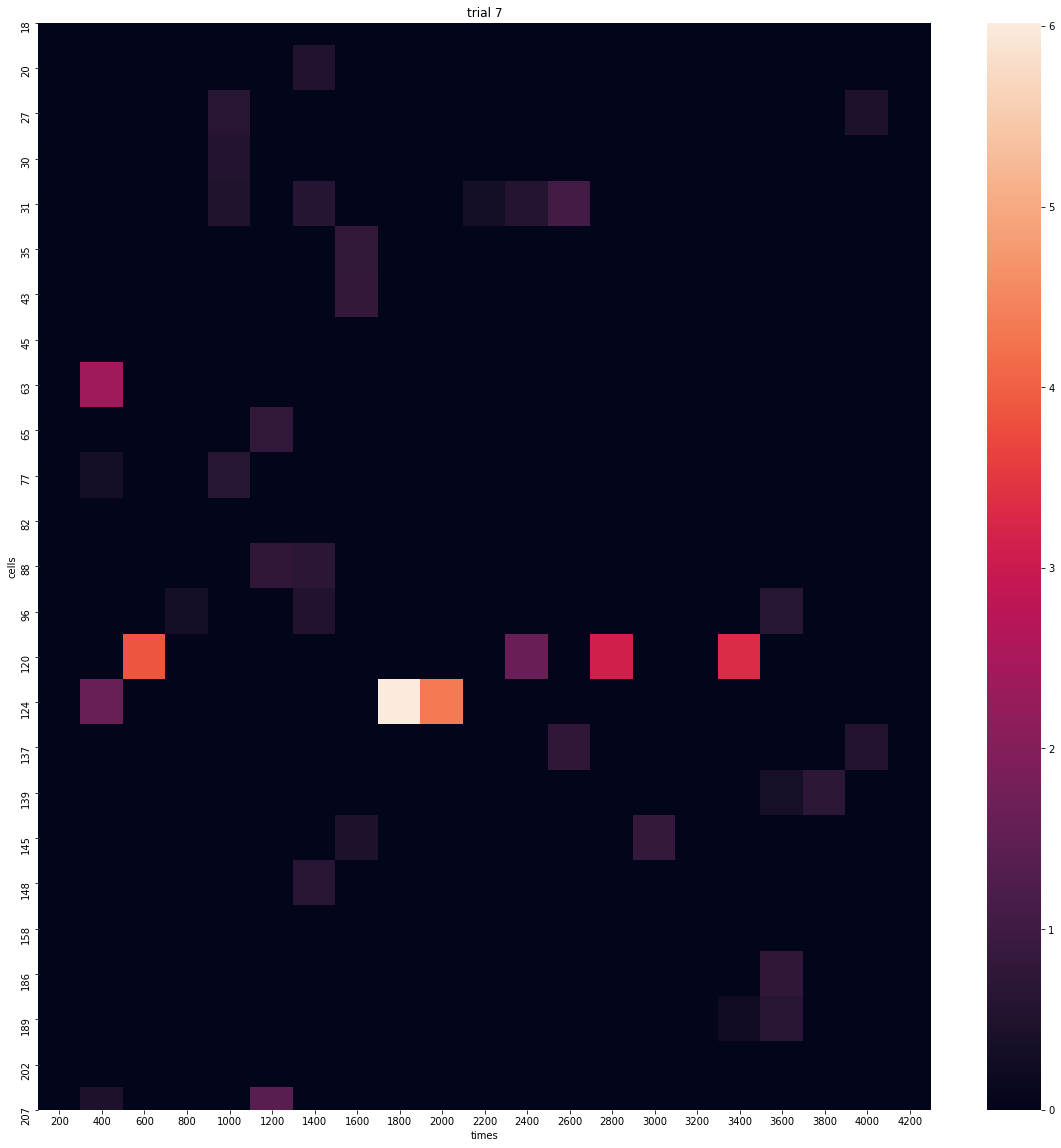

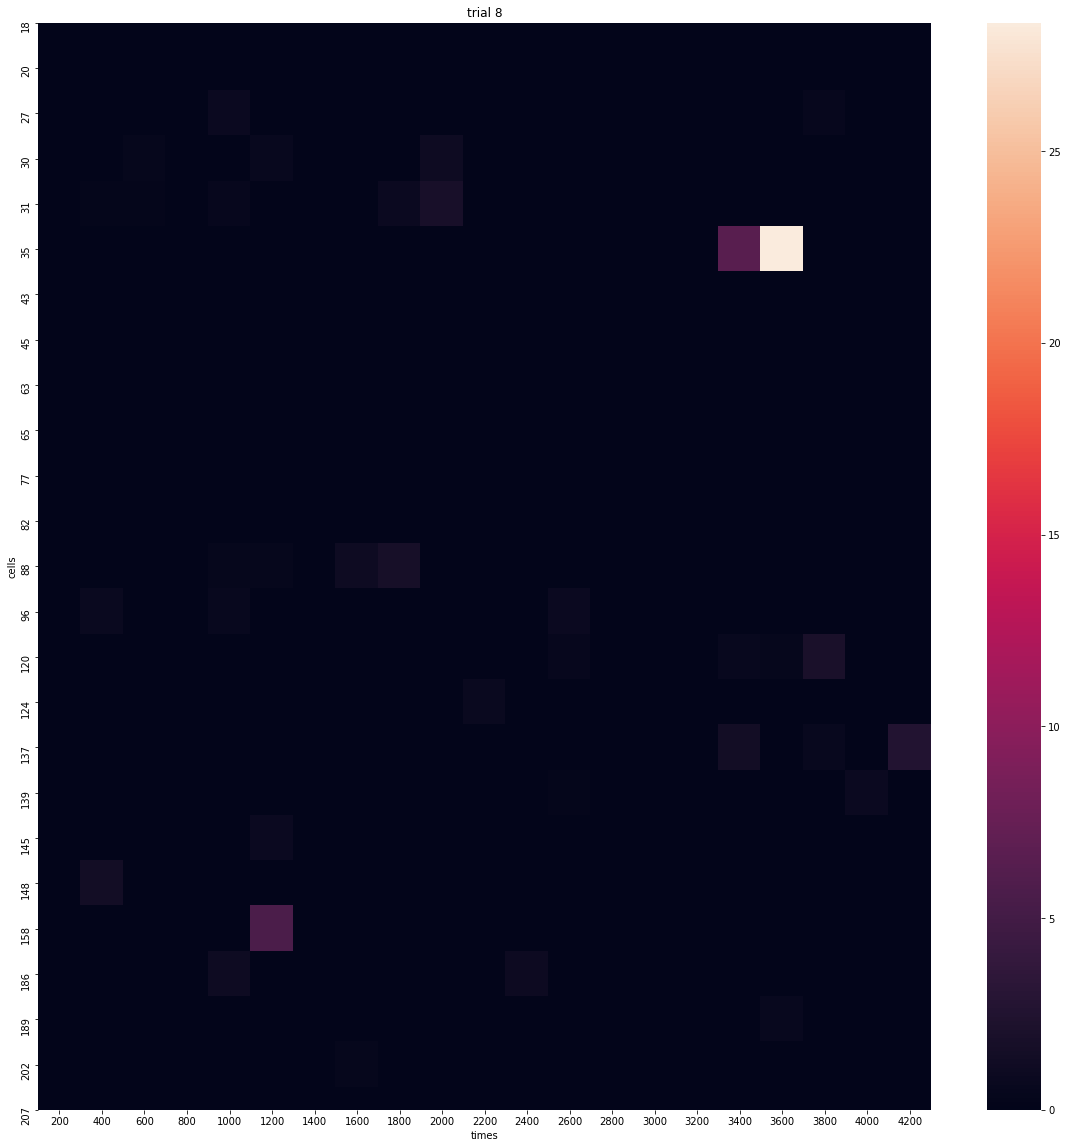

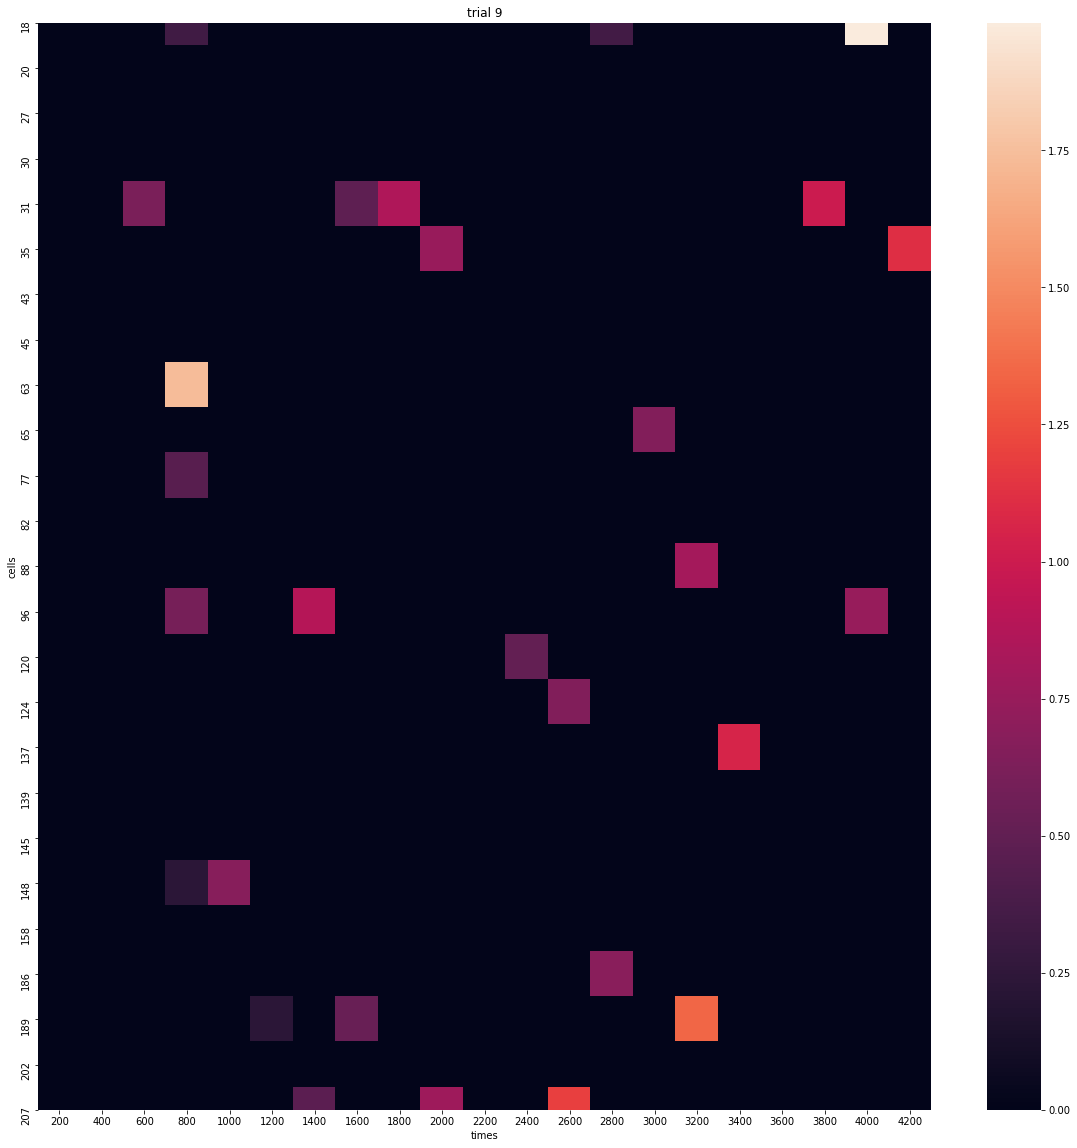

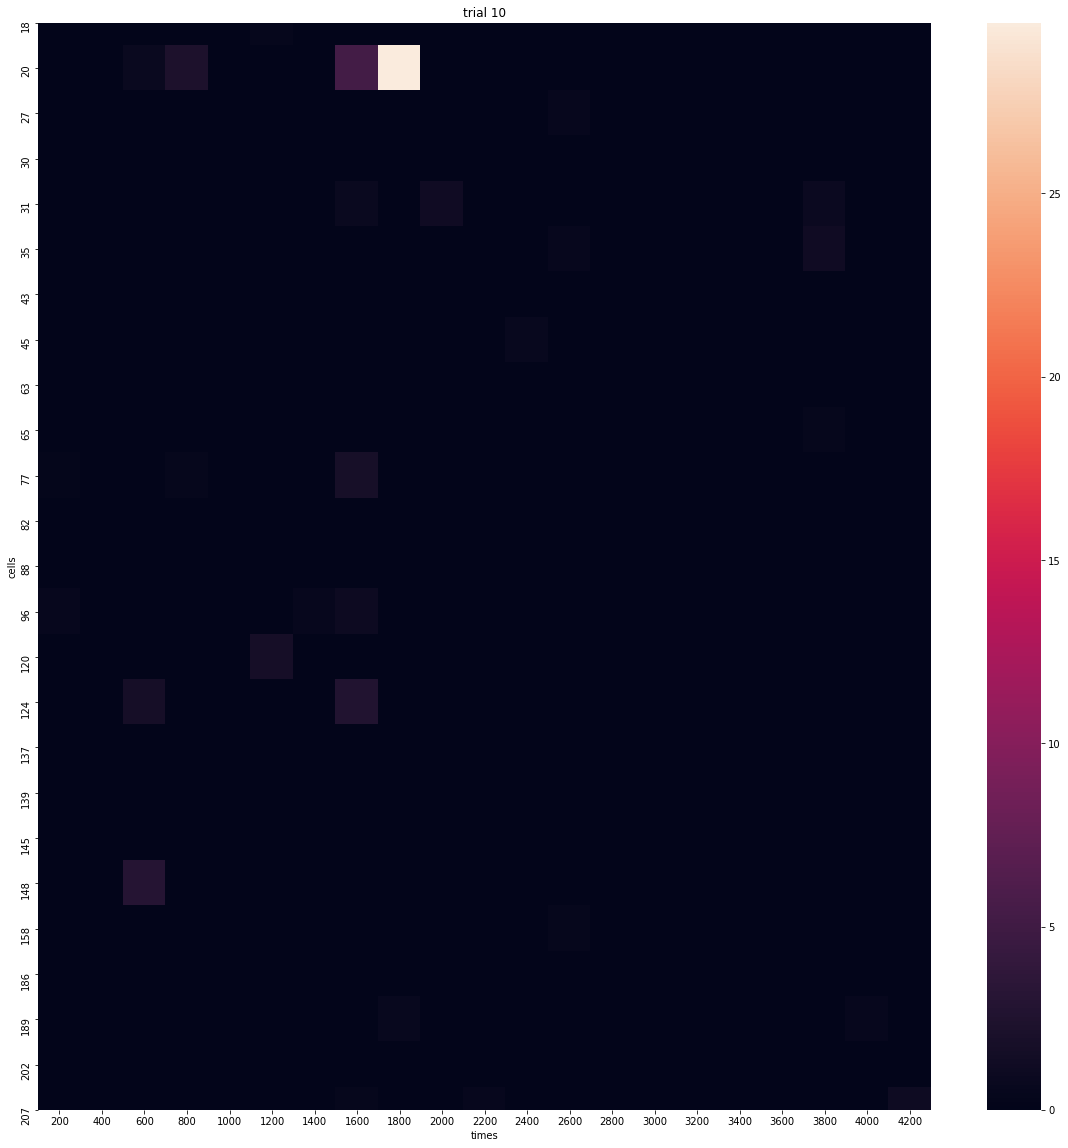

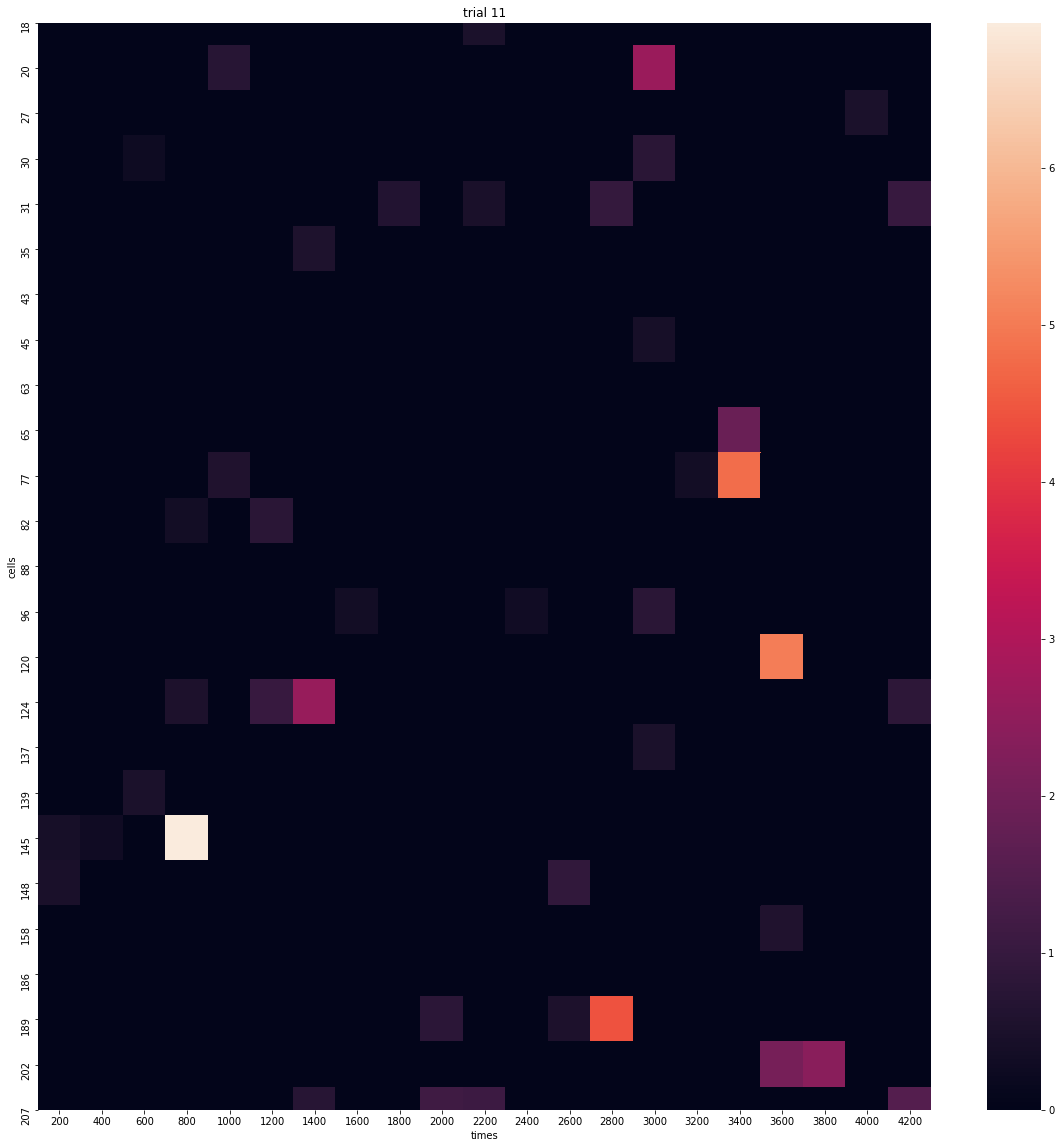

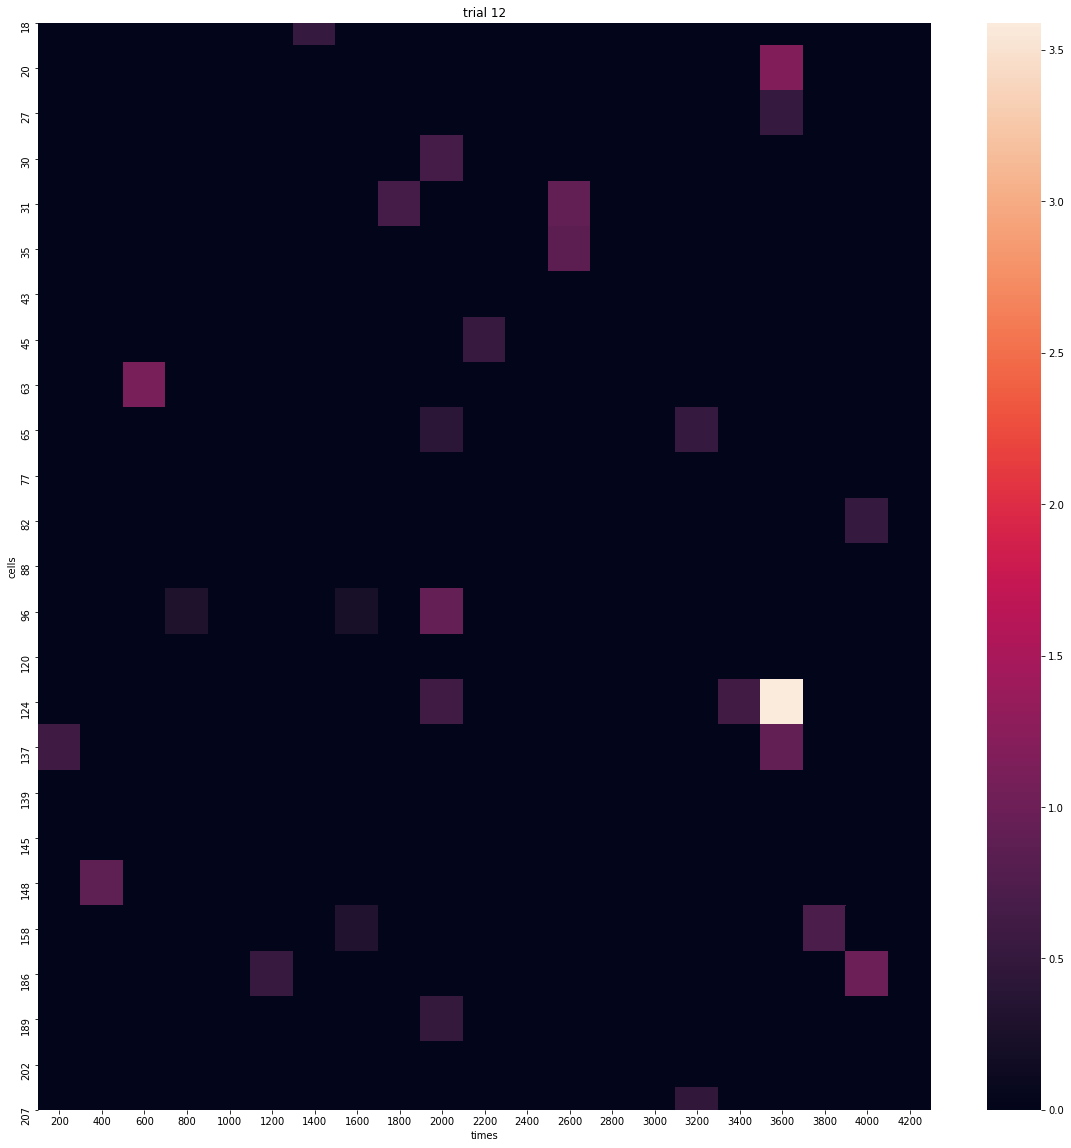

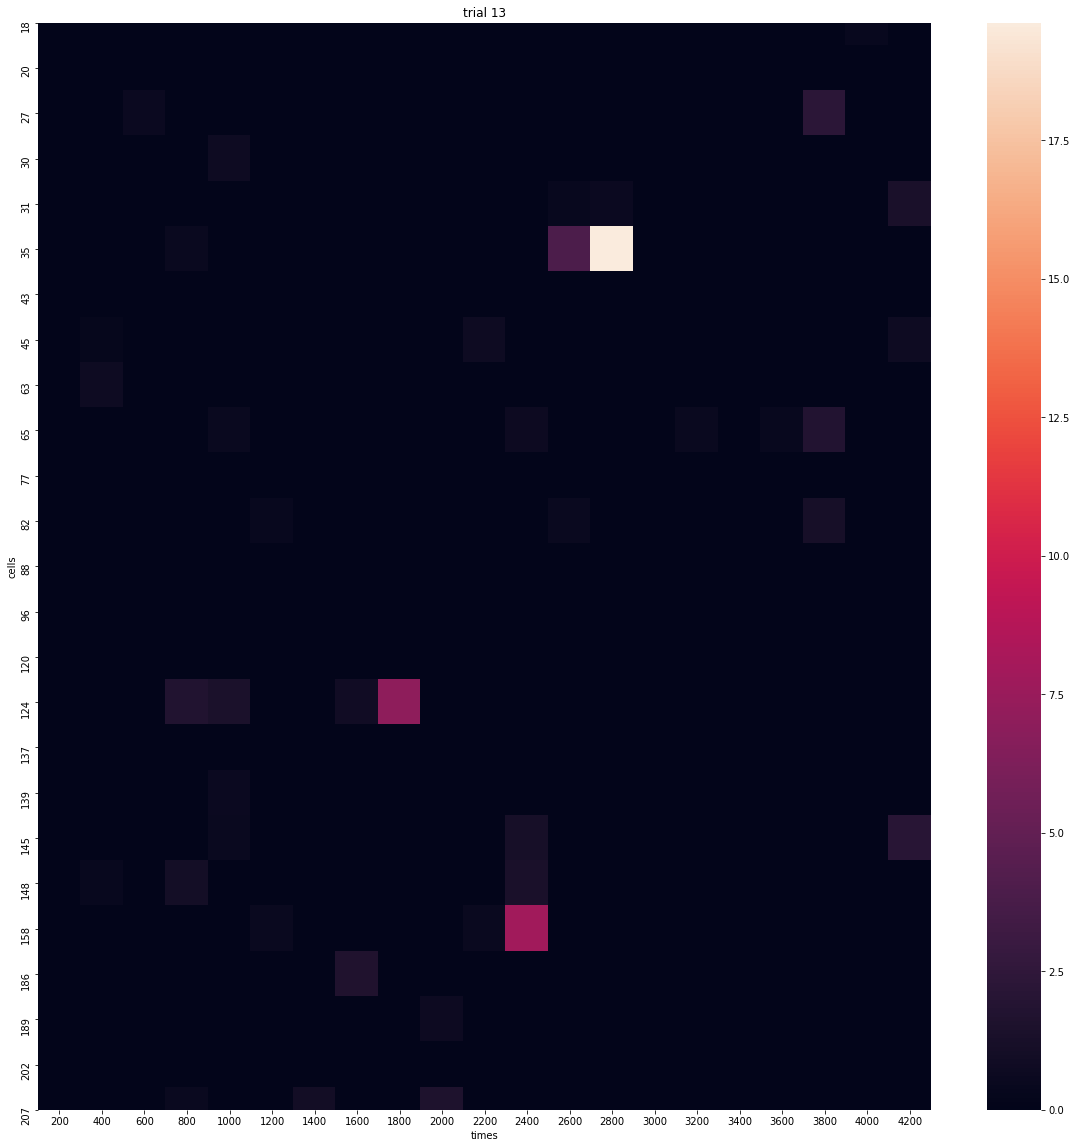

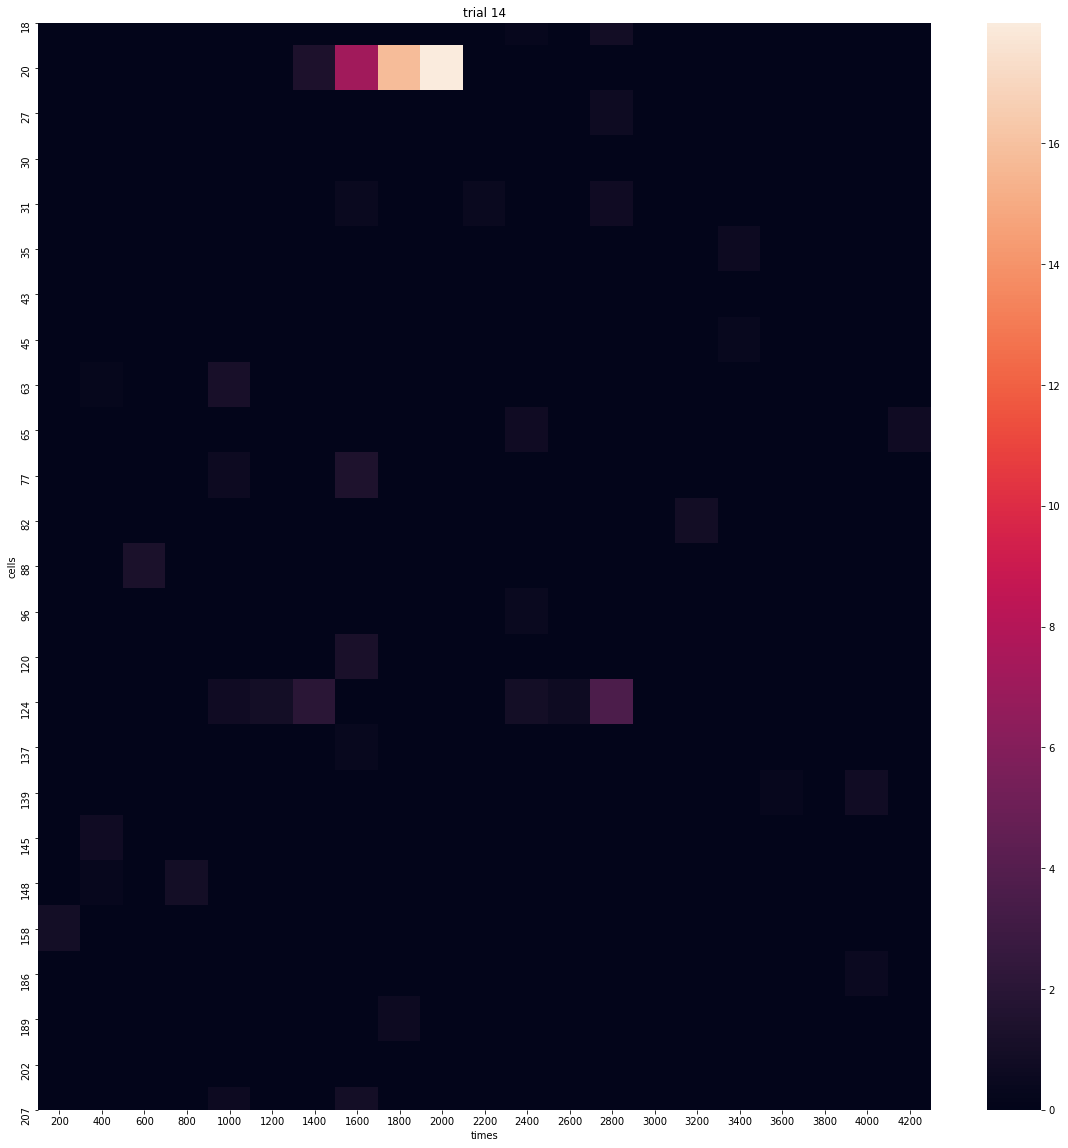

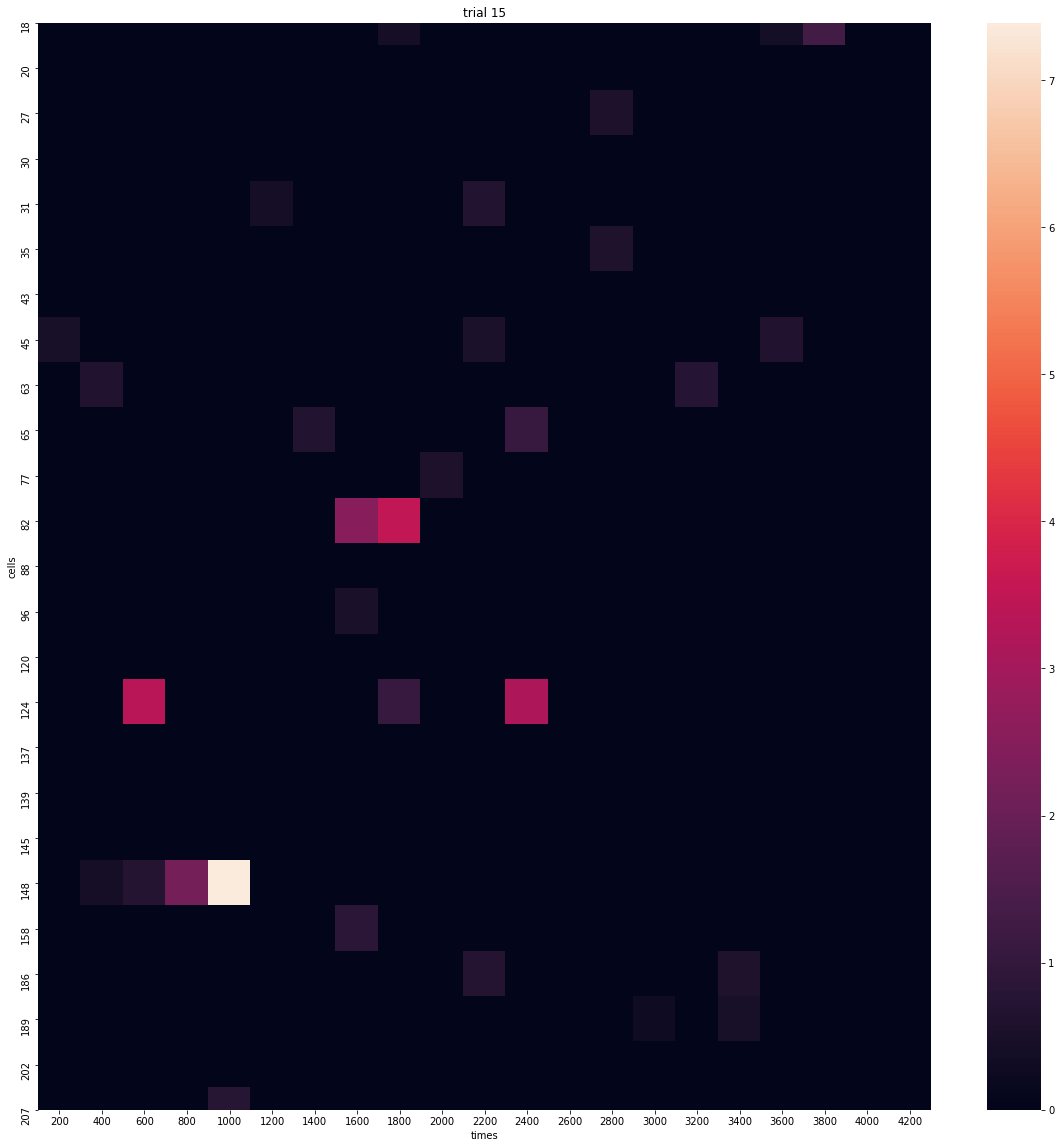

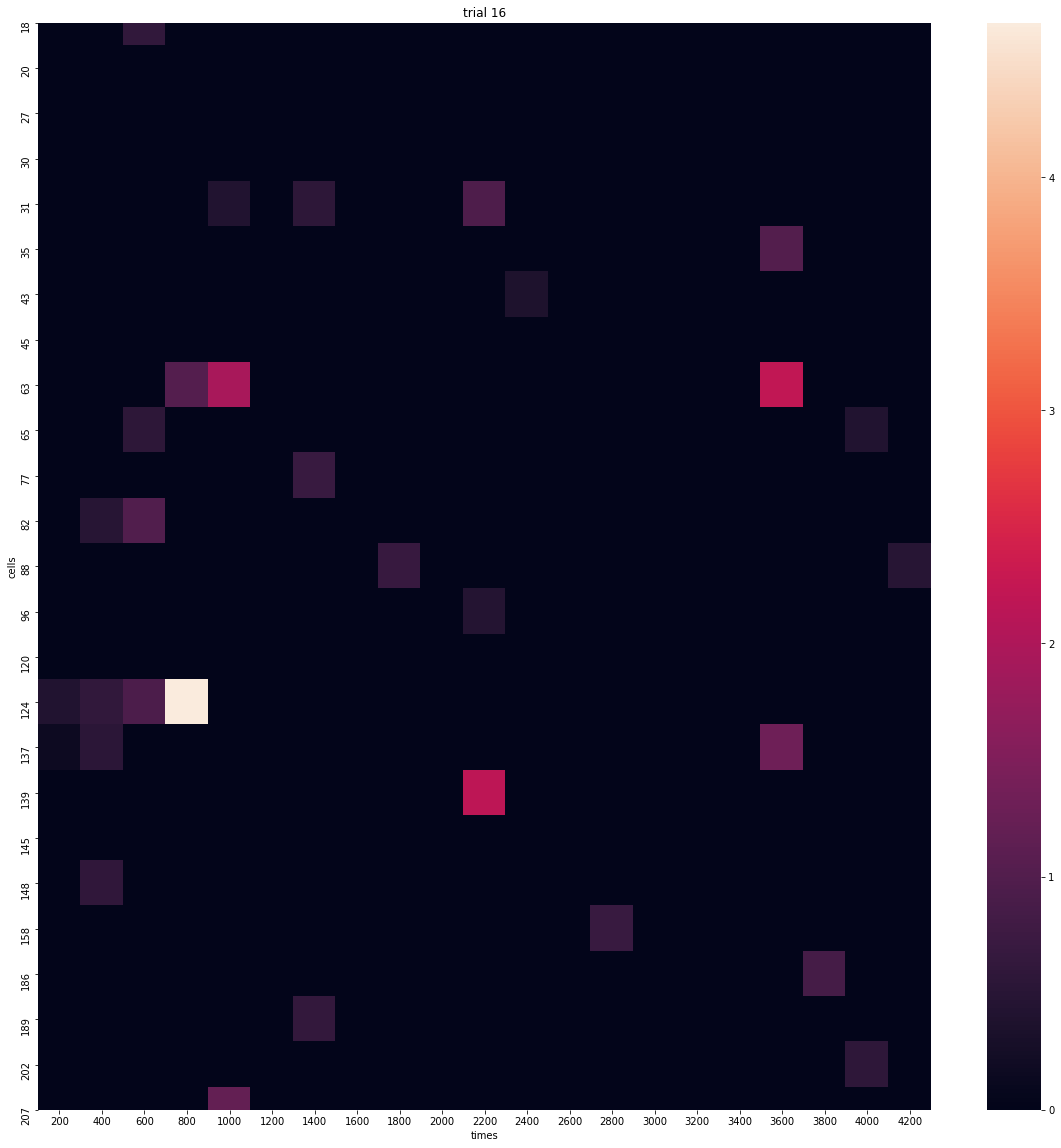

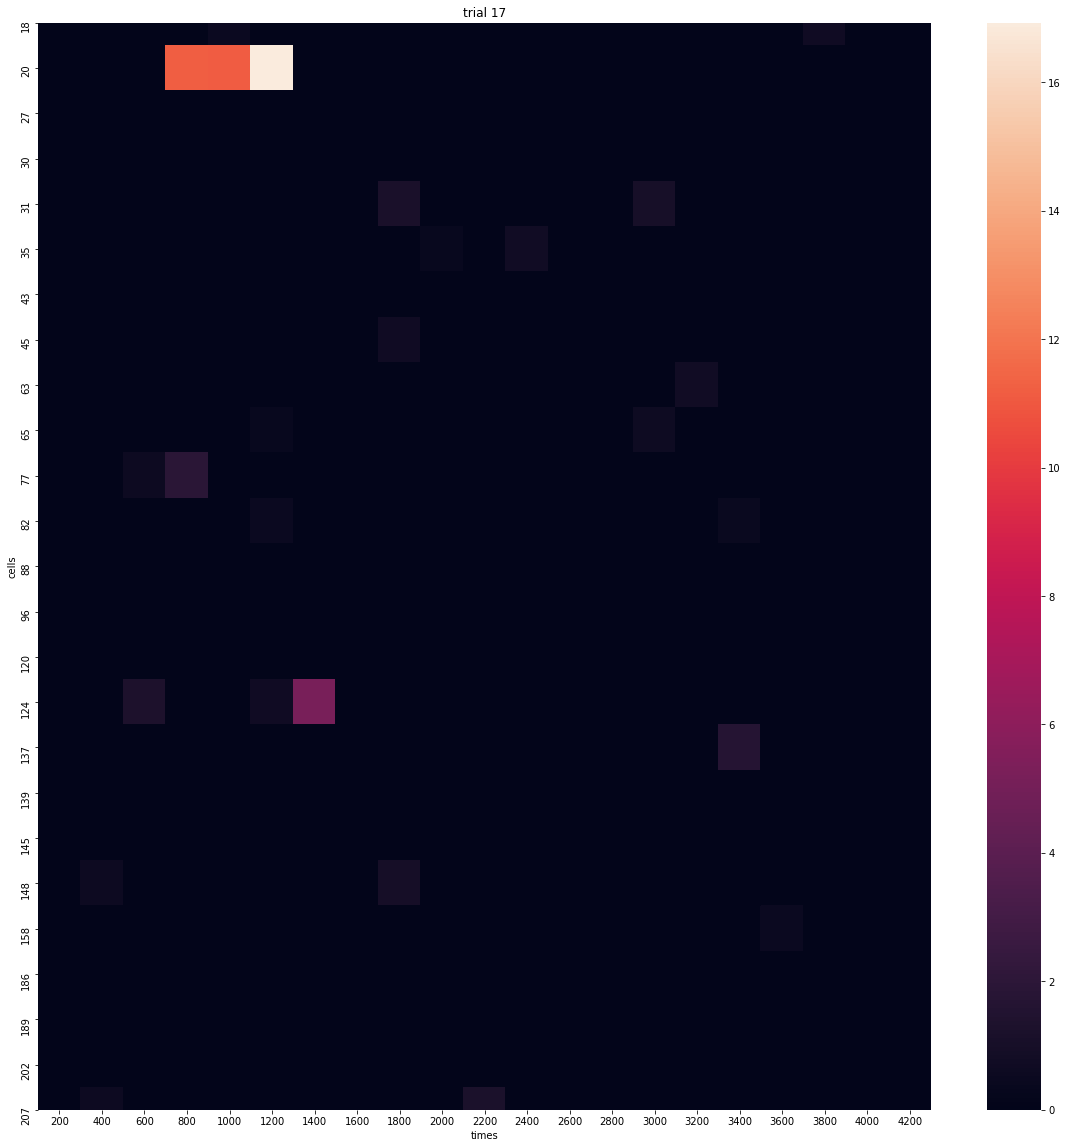

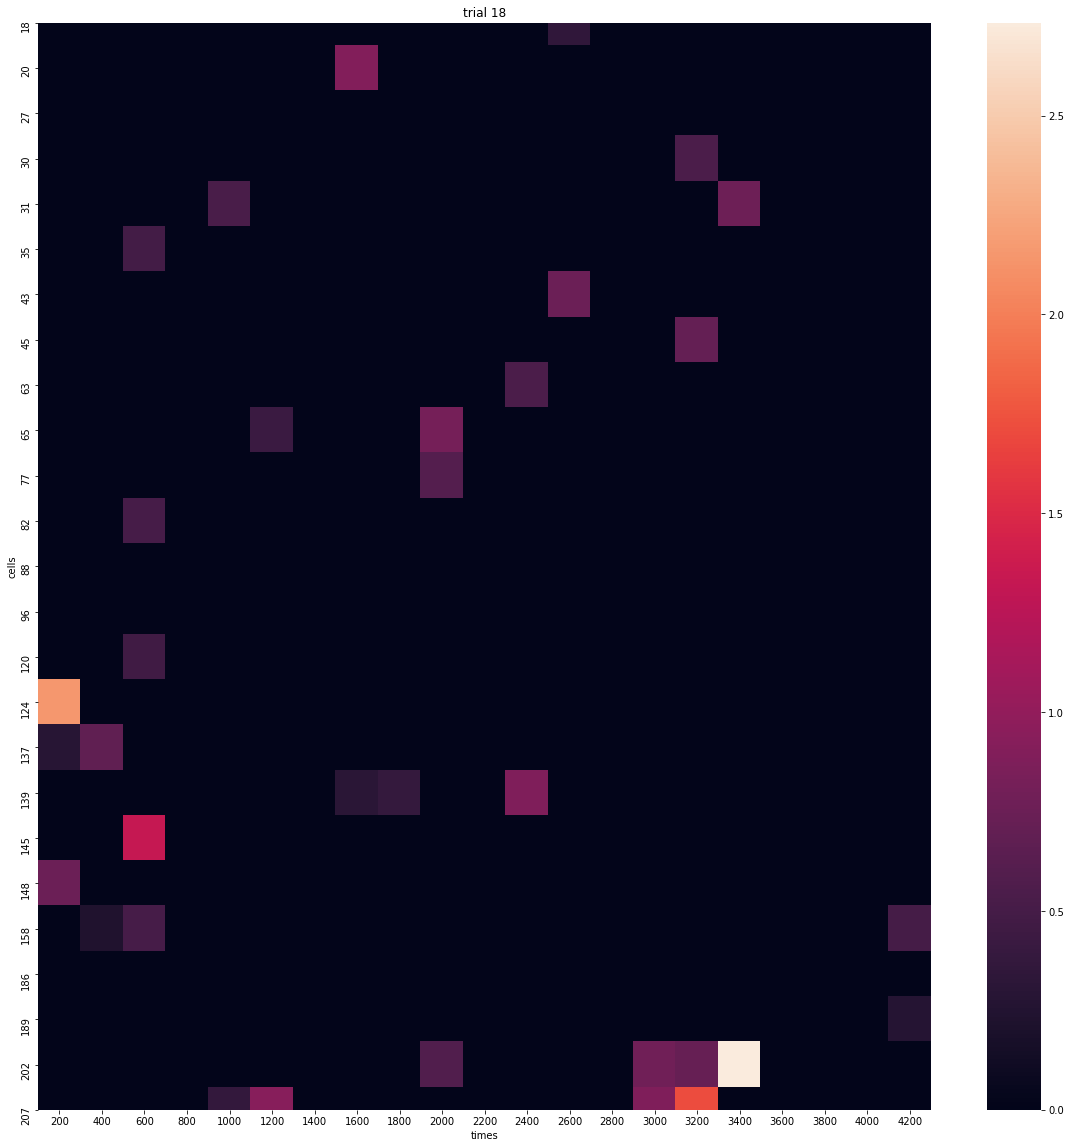

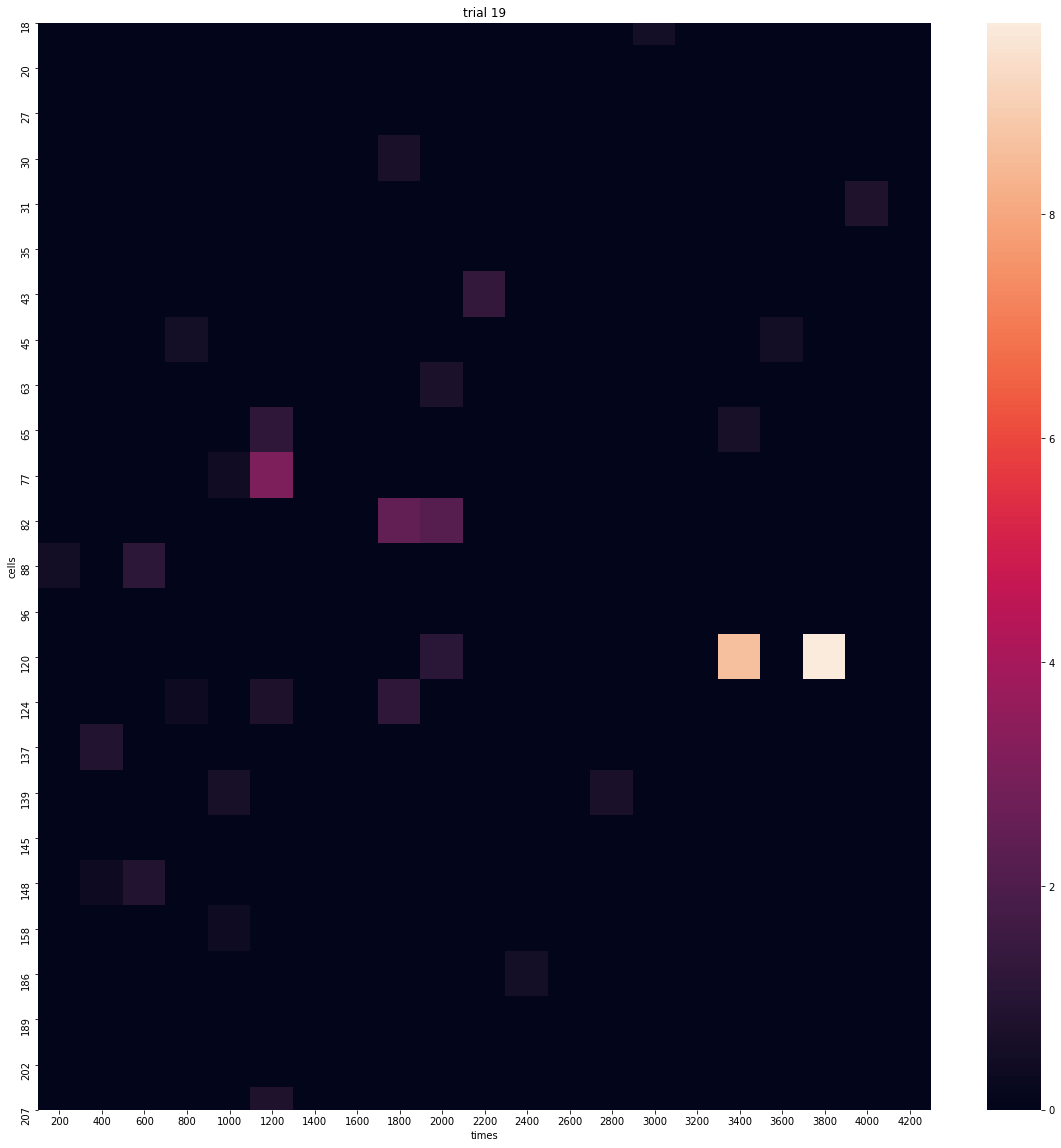

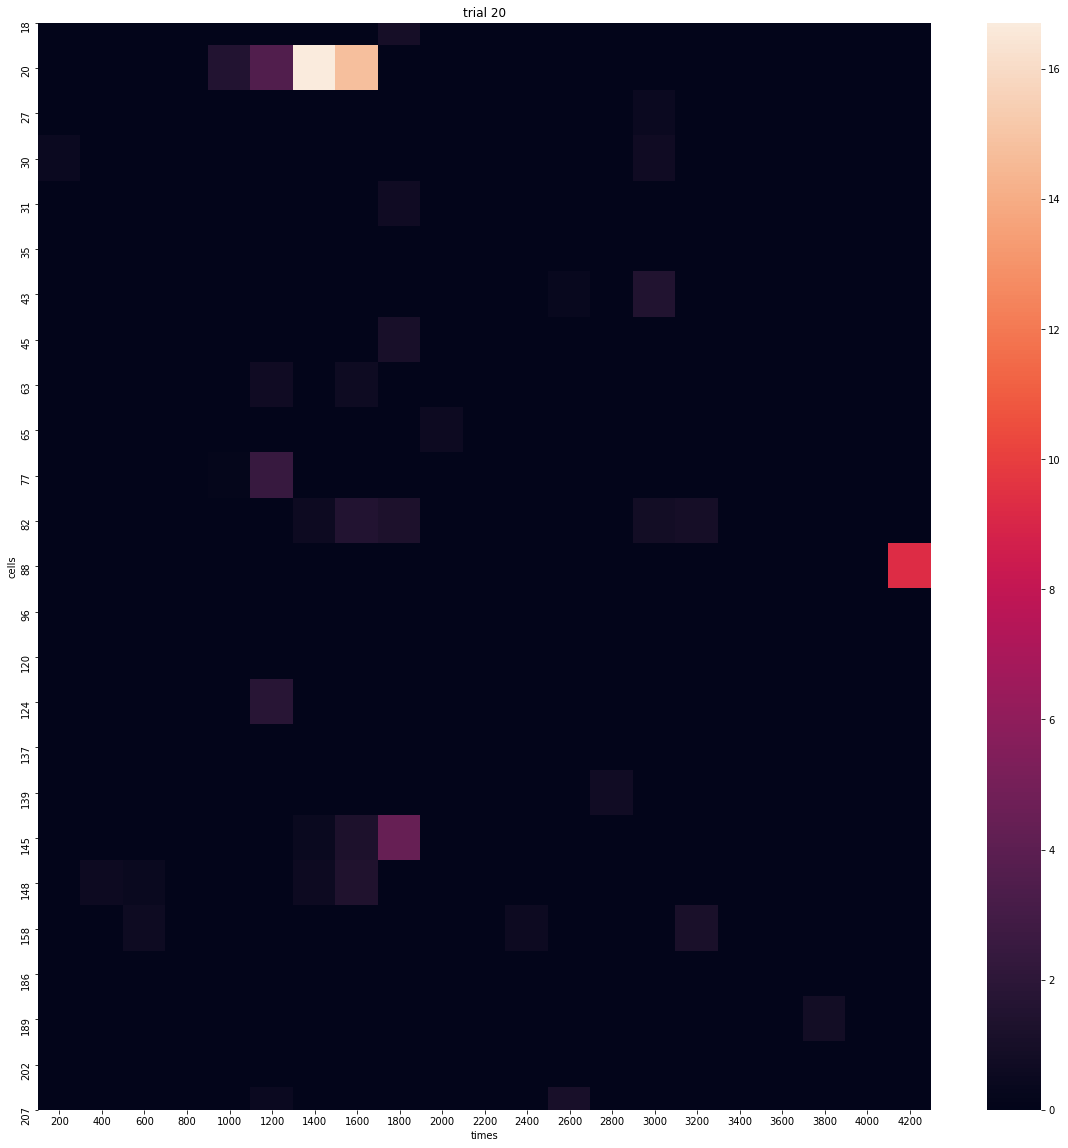

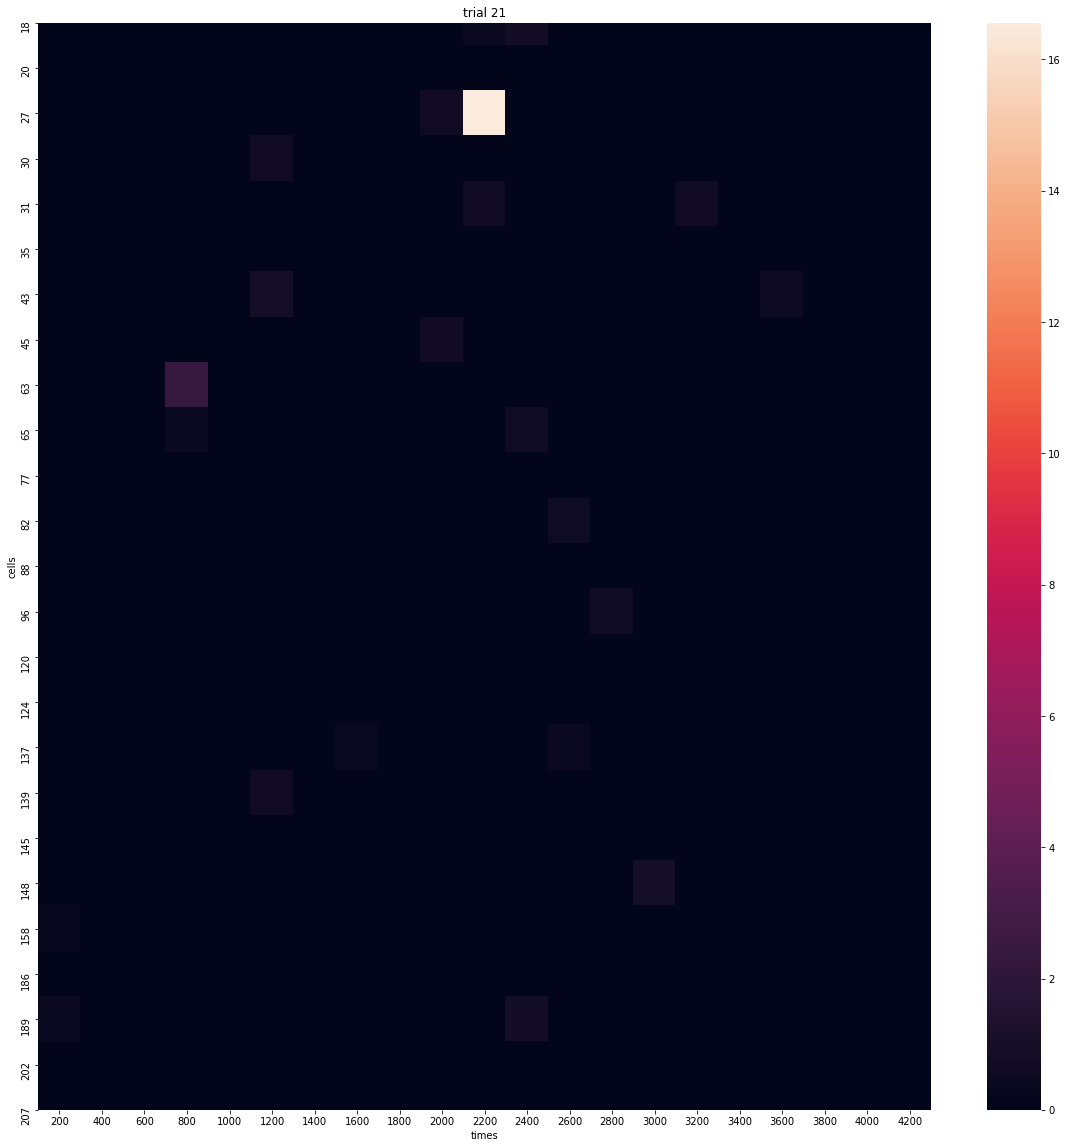

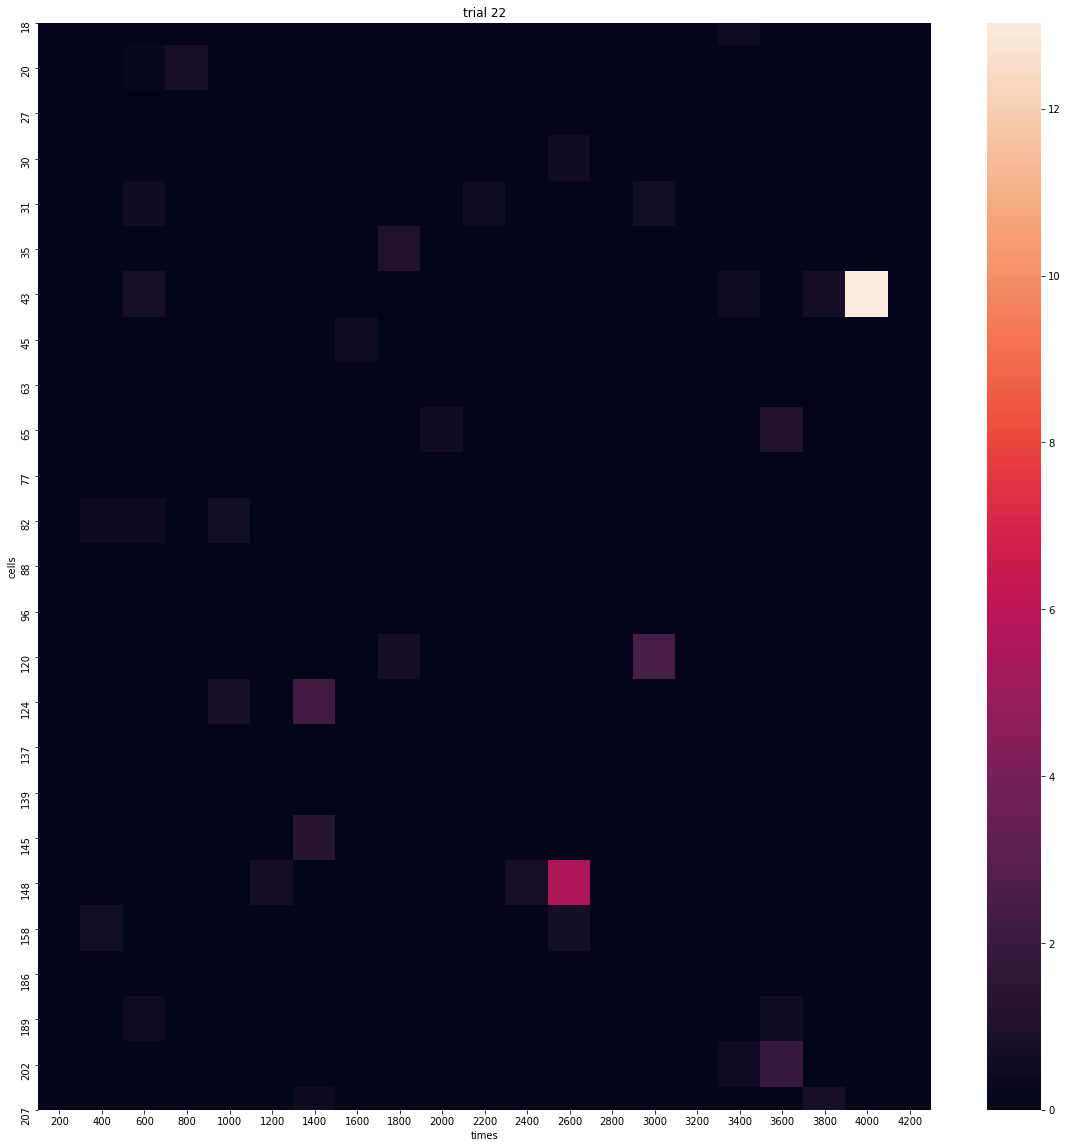

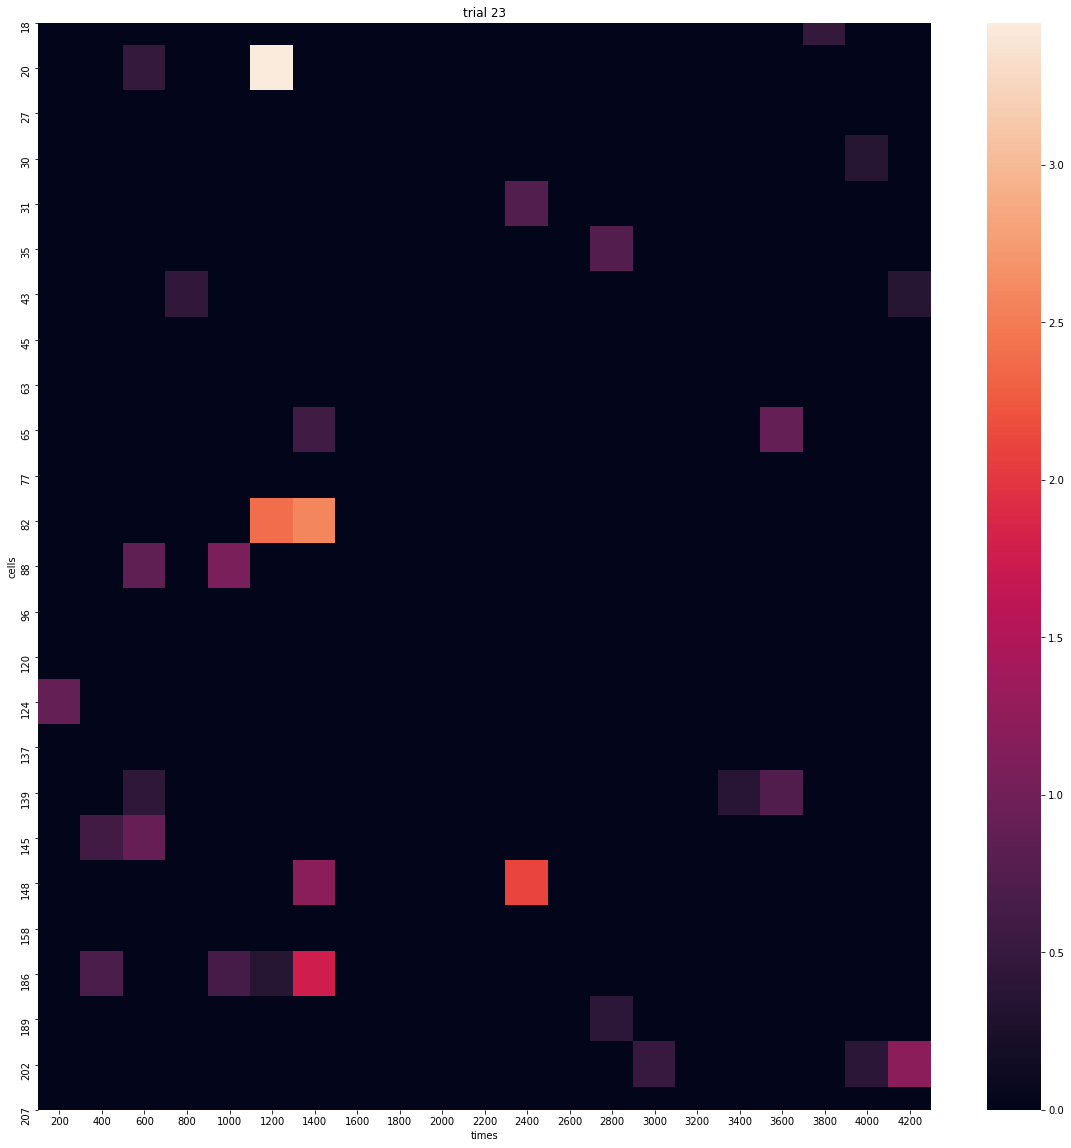

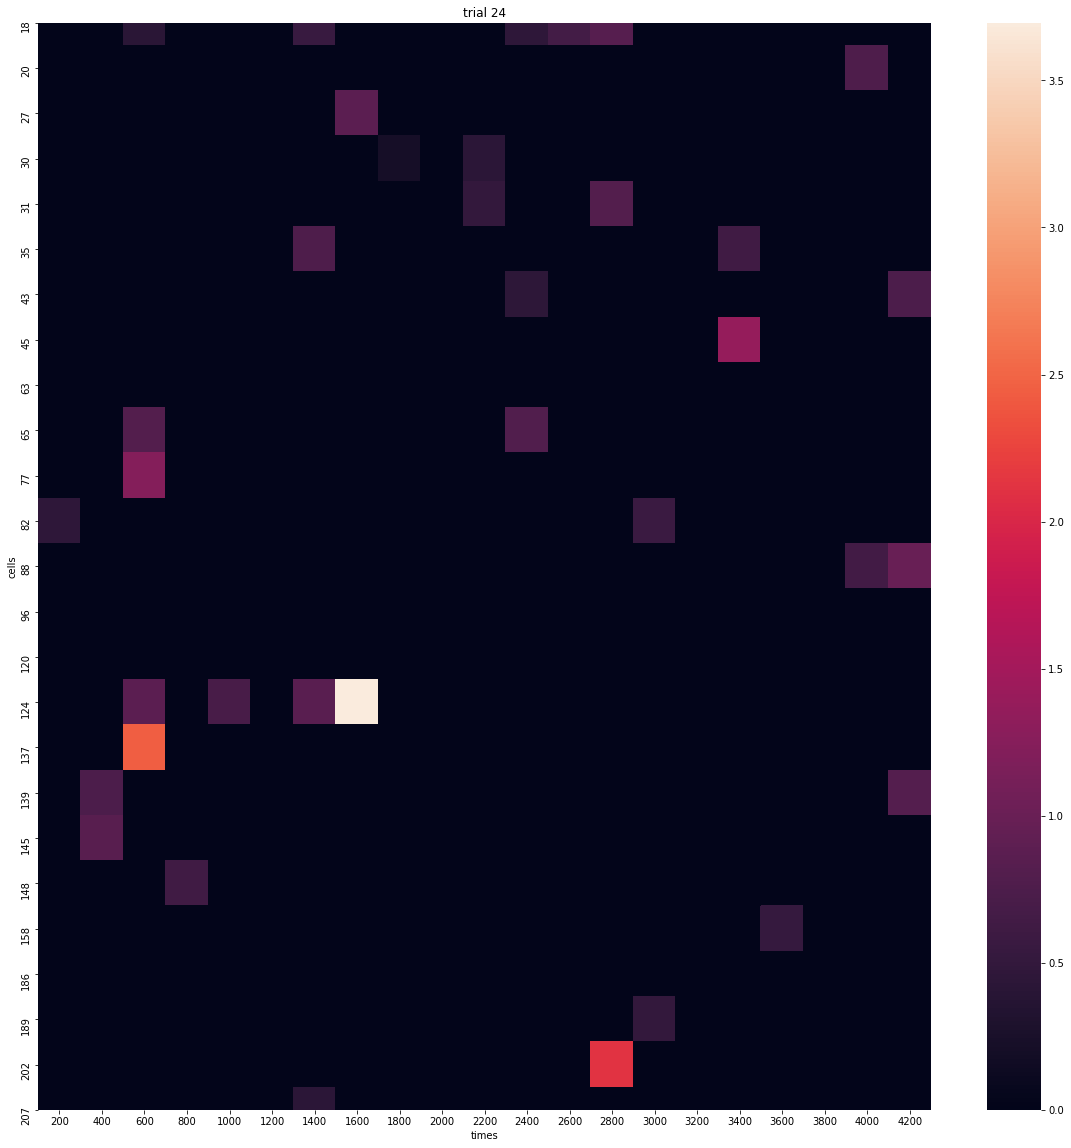

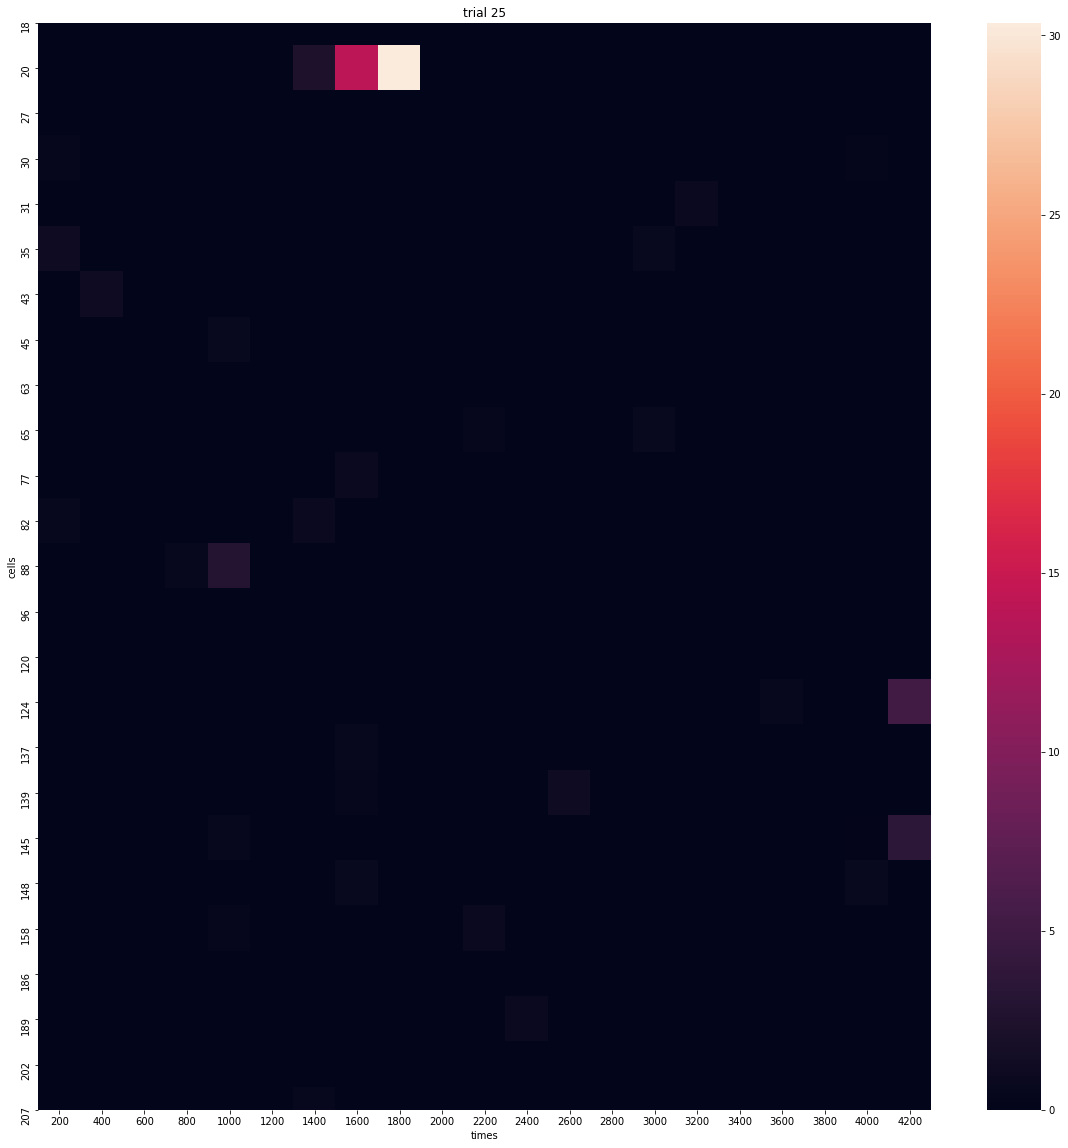

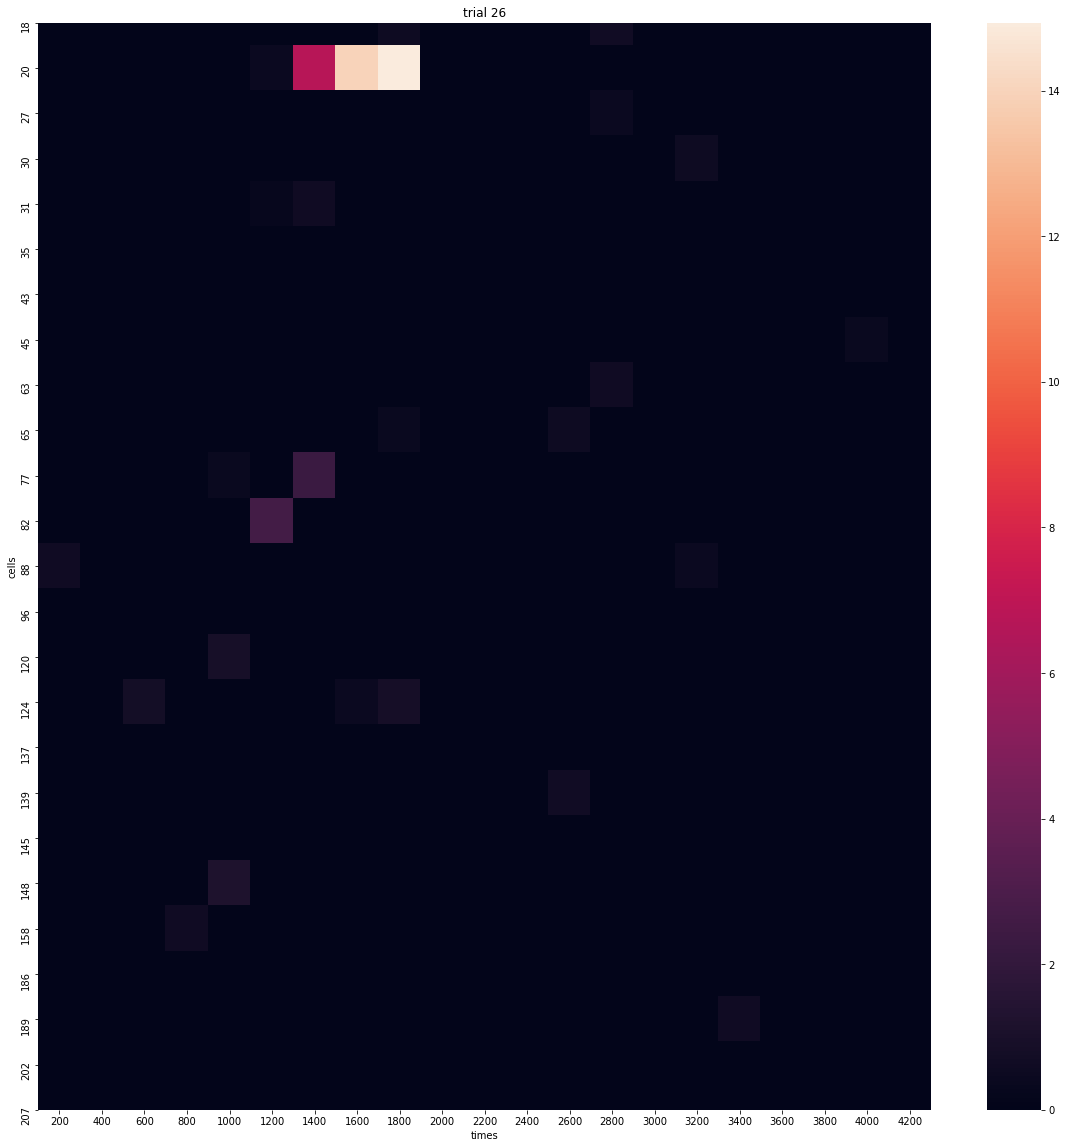

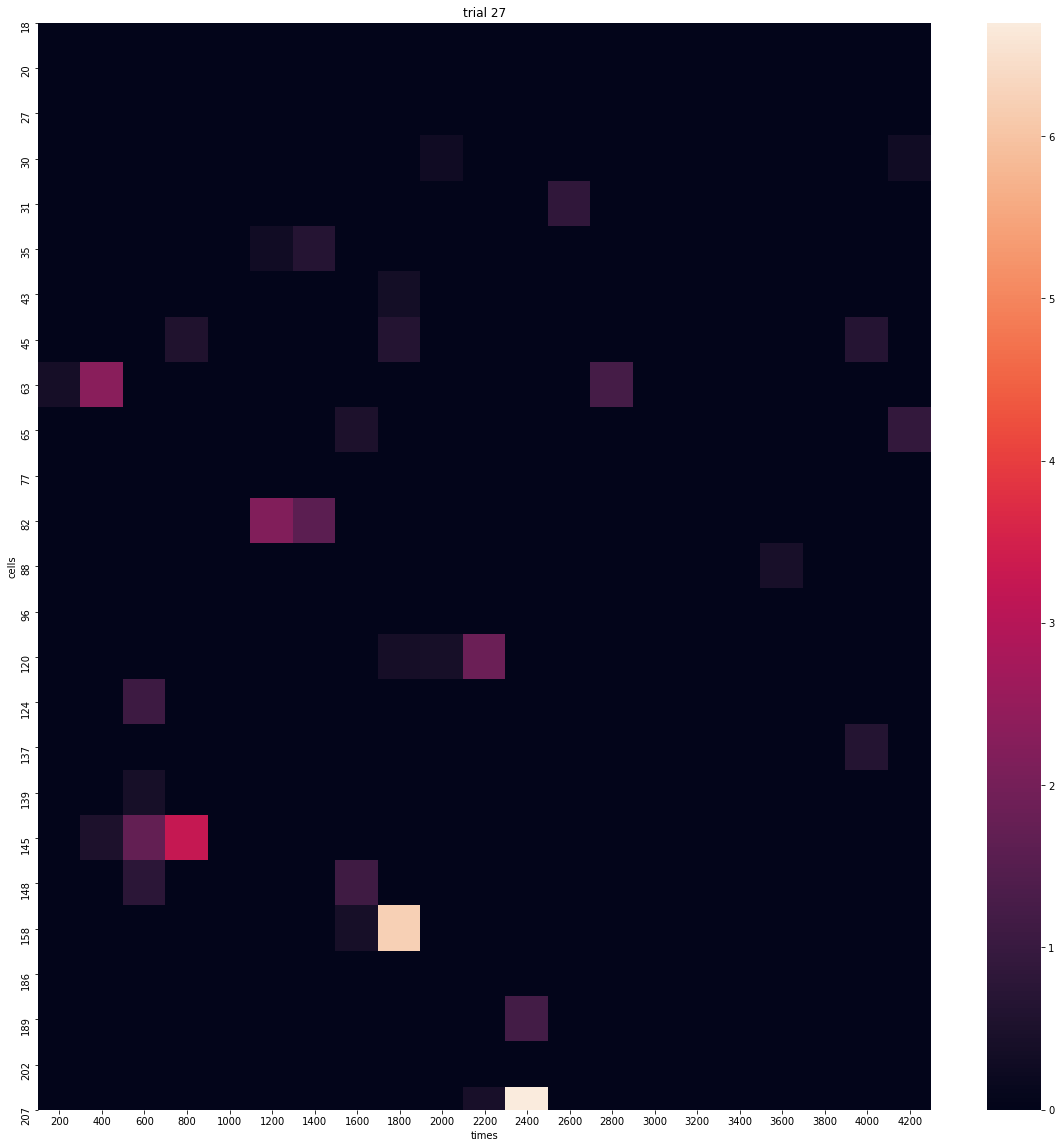

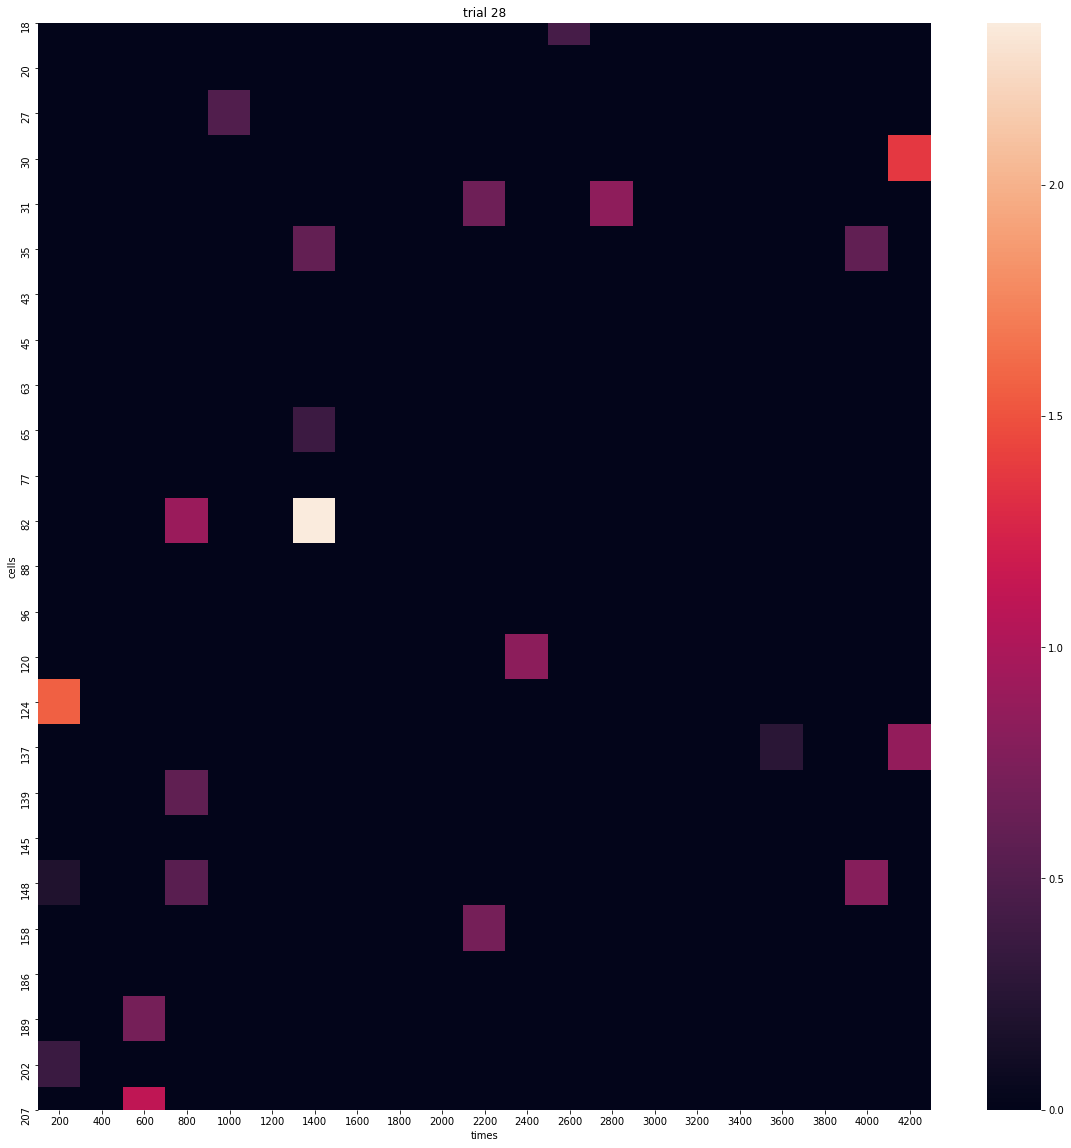

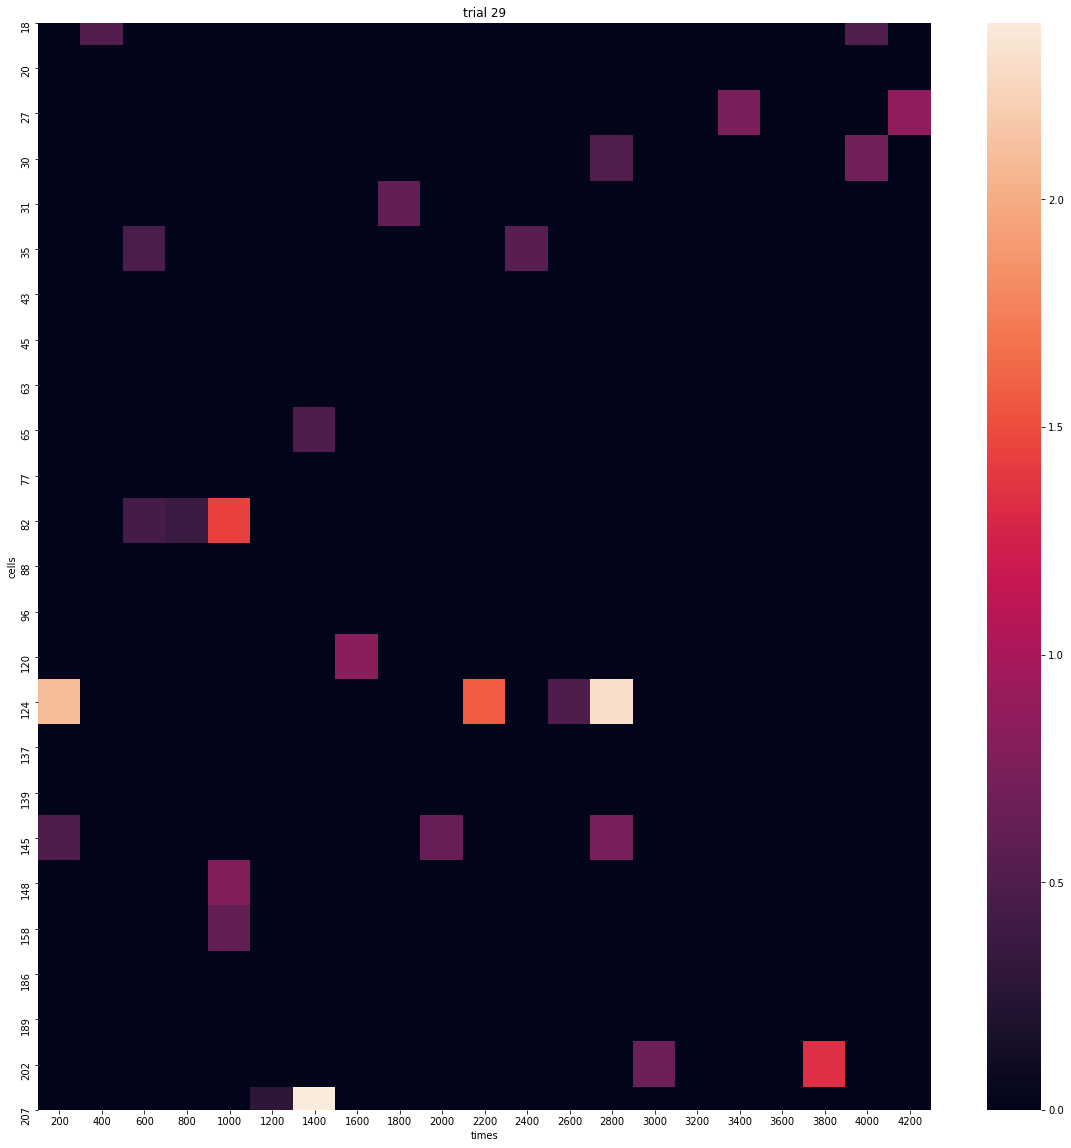

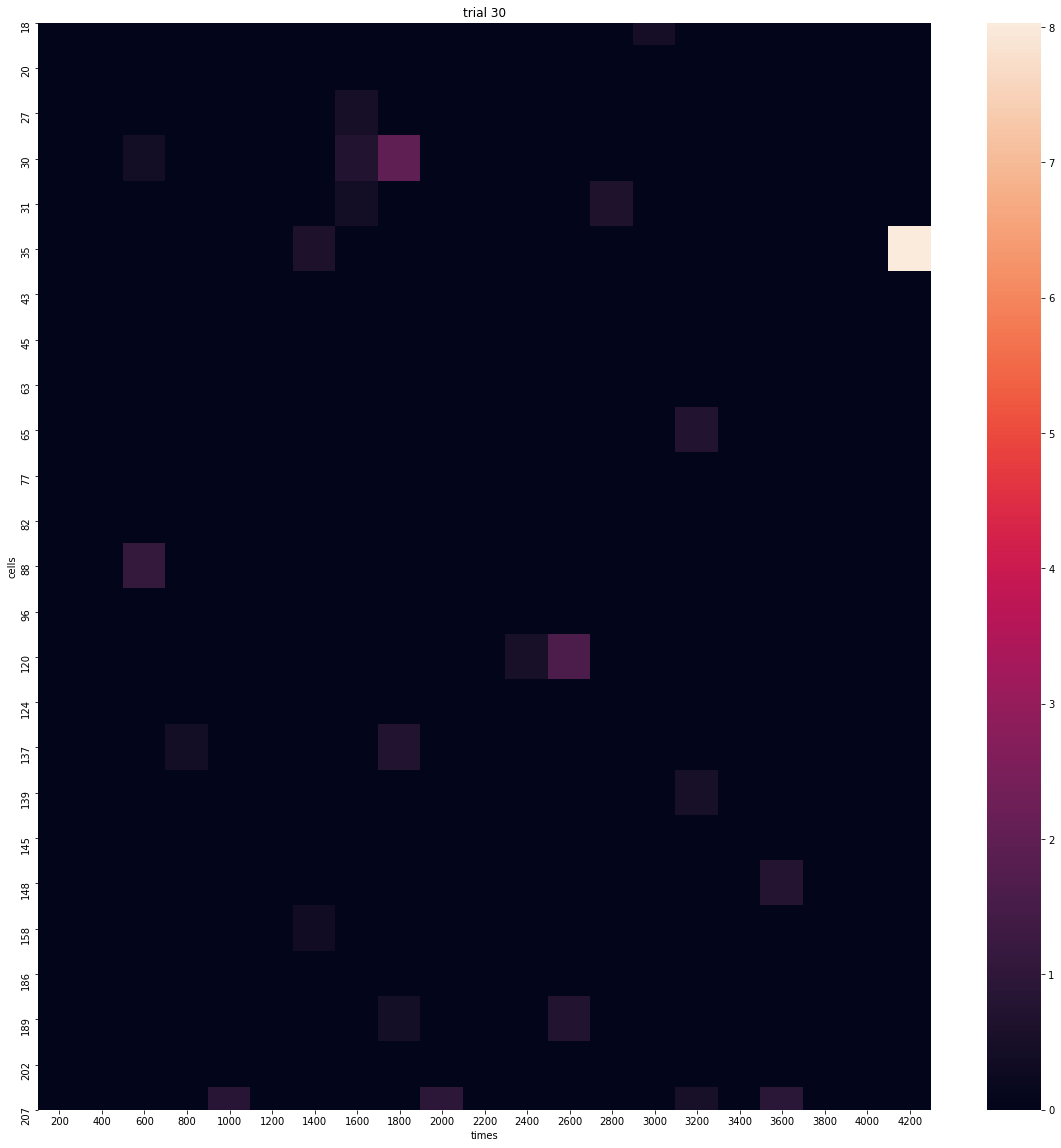

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#os.mkdir("./plots")
print("binned dic")

time_cells = [137, 139, 145, 18, 148, 20, 27, 30, 31, 158, 35, 43, 45, 186, 189, 63, 65, 202, 77, 207, 82, 88, 96, 120, 124]
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells,spikes = [],[],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell not in time_cells:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            times.append(time)
            cells.append(cell)
            spikes.append(mean_activity)
    data_dic = {}
    data_dic["times"] = times
    data_dic["cells"] = cells
    data_dic["spikes"] = spikes

    df = pd.DataFrame.from_dict(data_dic)
    df = df.pivot(index='cells', columns='times', values='spikes')
    print(df.head())
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.title("trial "+str(trial))
    sns.heatmap(df, annot=False)
    plt.savefig("plots/trial"+str(trial)+".png")

# Make heatmap of average activity for time cells avrgd over all trials

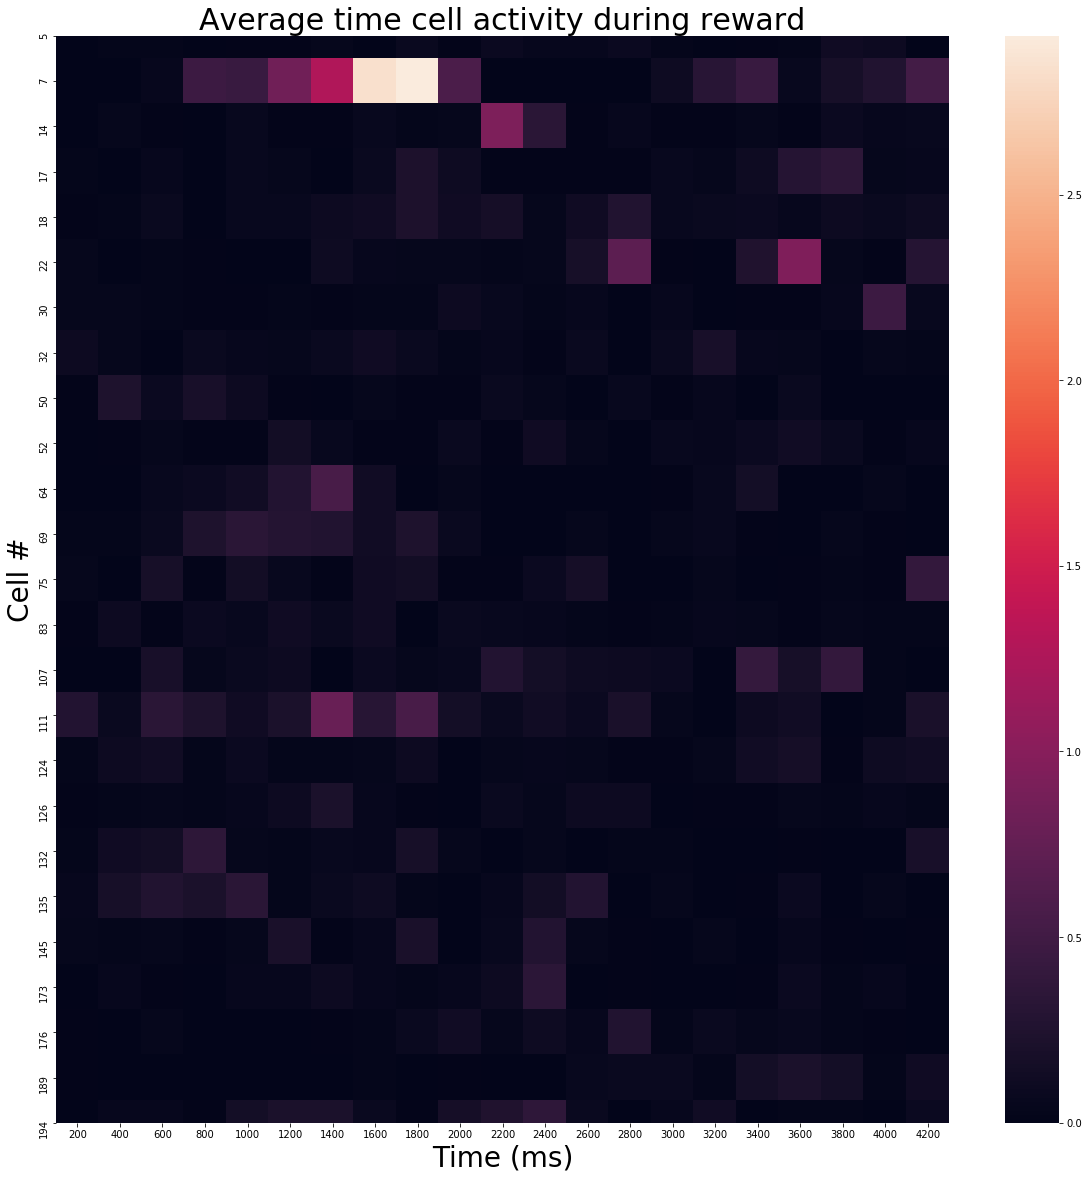

In [13]:
c=0
data_dic = {}
spikes = {}
for trial,bin in binned_dic.items():
    #print("trial:", trial)
    times,cells = [],[]
    for time,activities in bin.items():
        #print("time:", time)
        for cell,v in activities.items():
            if cell not in time_cells:  # to skip over behavior and metadata
                continue
            activity_sum = 0
            count = 0
            for x in v:
                activity_sum += x
                count += 1
            mean_activity = activity_sum / count
            #print("time:", time, "cell:", cell, "mean_act:", mean_activity)
            if c == 0:
                times.append(time)
                cells.append(cell-13)
            if (time,cell) not in spikes:
                spikes[(time,cell)] = []
                spikes[(time,cell)].append(mean_activity)
            else:
                spikes[(time,cell)].append(mean_activity)

data_dic["times"] = times
data_dic["cells"] = cells

spikes_list = []
for k,v in spikes.items():
    spikes_list.append(sum(v) / len(v))

data_dic["spikes"] = spikes_list


df = pd.DataFrame.from_dict(data_dic)
df = df.pivot(index='cells', columns='times', values='spikes')
fig, ax = plt.subplots(figsize=(20,20)) 
#sns.set(font_scale=1.4)
b = sns.heatmap(df, annot=False)
b.axes.set_title("Average time cell activity during reward",fontsize=30)
b.set_xlabel("Time (ms)",fontsize=28)
b.set_ylabel("Cell #",fontsize=28)
plt.savefig("plots/avrg_activity_reward_0.png")